# Entrevista para Data Science
Santiago Martínez

# Ejercicio 1

## Consignas:
- Realizar un análisis exploratorio del dataframe.
- Realizar el tratamiento requerido para unificar toda la información en un solo dataframe
y poder entrenar un modelo.
- Entrenar los modelos que se consideren pertinentes al enunciado.
- Comparar los modelos entrenados por las métricas que considere aplicables a la
naturaleza del problem

En primer lugar procederemos a unificar cada hoja del xlsx en un archivo de una misma "hoja" y llevarlo a un csv. Principalmente para facilitar todos los pasos posteriores

Cargamos el dataframe original en distintas hojas:

In [108]:
import pandas as pd
from pathlib import Path 
import matplotlib.pyplot as plt

file = Path("datasets/Dataset_Inmuebles.xlsx")

print(file)

# Open the Excel file
sheet_1 = pd.read_excel(file, sheet_name='Inputs_1')
sheet_2 = pd.read_excel(file, sheet_name='Inputs_2')
sheet_3 = pd.read_excel(file, sheet_name='Inputs_3')

print(sheet_1.columns)
print(sheet_2.columns)
print(sheet_3.columns)


datasets/Dataset_Inmuebles.xlsx


Index(['ID', 'property_type', 'lat', 'lon', 'description', 'title'], dtype='object')
Index(['ID', 'price_usd', 'surface_total', 'surface_covered', 'floor', 'rooms',
       'expenses'],
      dtype='object')
Index(['ID', 'barrio', 'comuna'], dtype='object')


Inicialmente podríamos suponer que estos datos no están alterados, de forma tal que existe la misma cantidad de IDs en cada hoja, pero por las dudas haré un par de pruebas

In [109]:
def ID_check(dataframe):

    print('Cantidad total: ', len(dataframe.ID))
    print('Máximo valor: ', max(dataframe.ID))
    print('Mínimo valor: ', min(dataframe.ID))
    print('Cantidad de duplicados: ', sum(dataframe.ID.duplicated()))
    print('-------')

print('sheet_1:')
ID_check(sheet_1)
print('sheet_2:')
ID_check(sheet_2)
print('sheet_3:')
ID_check(sheet_3)


sheet_1:
Cantidad total:  10567
Máximo valor:  10566
Mínimo valor:  0
Cantidad de duplicados:  0
-------
sheet_2:
Cantidad total:  10567
Máximo valor:  10566
Mínimo valor:  0
Cantidad de duplicados:  0
-------
sheet_3:
Cantidad total:  10567
Máximo valor:  10566
Mínimo valor:  0
Cantidad de duplicados:  0
-------


Los tres dataframes tienen la misma cantidad de valores, el rango, el máximo y el mínimo son iguales. Y finalmente no hay duplicados

Esta prueba sirve también para evitar errores a la hora de mergear las distintas hojas.

Se realiza el mergeo de los tres dataframes usando el ID como valor de referencia. 

Se toma el criterio de ordenar la primera página para que el indix respete el valor del ID (ordenar o no los demás dataframes es redundante ya que lo hará automaticamente el merge al hacerlo en base al ID)

In [110]:
dataframe = pd.merge(sheet_1.sort_values(by="ID"), sheet_2, on='ID')
dataframe = pd.merge(dataframe, sheet_3, on='ID')
dataframe.set_index('ID')
dataframe_original=dataframe.copy()

## Análisis de las columnas

Contamos con las siguientes columnas:
- property_type
- lat
- lon
- description
- title
- price_usd
- surface_total
- surface_covered
- floor
- rooms
- expenses
- barrio
- comuna

De estas tendré que analizar que contenido tienen, si cuentan con nulos o no

In [111]:
NUMBER_OF_ROWS = len(dataframe['ID'])
NUMBER_OF_ROWS

10567

In [112]:
def number_of_nulls(dataframe,col):
    if sum(dataframe[col].isnull()) == 0:
        print(col, sum(dataframe[col].isnull()))
    else:
        print(col, sum(dataframe[col].isnull()),
         f'{round((sum(dataframe[col].isnull())/ NUMBER_OF_ROWS*100),2)}%' )

for col in dataframe.columns:
    number_of_nulls(dataframe,col)

ID 0
property_type 488 4.62%
lat 0
lon 0
description 0
title 0
price_usd 0
surface_total 0
surface_covered 0
floor 8850 83.75%
rooms 0
expenses 8032 76.01%
barrio 0
comuna 0


Tenemos 3 columnas con nulos:
- property_type (4.6%)
- floor (83.75%)
- expenses (76.01%)

Afortunadamente, si se hace un análisis más conceptual de cada columna, esto no debería traer muchos problemas ya que:
- los nulos en property_type son pocos, y todavía queda pendiente obtenerlo del title. Al hacer un analisis visual tomo como hipotesis que todos los títulos terminan con el tipo de propiedad
- los nulos en floor son mucho más altos y quizás sea dificil obtenerlo de description y title (habria que tomar en cuenta que los floor de casas deberían ser 0). De todas formas me animo a decir a priori que el piso del departamento no tiene una influencia directa en el precio.
- los nulos de expenses son menores a los de floor pero siguen siendo considerablemente altos en proporción. 

## Análisis de property_type

In [113]:
dataframe.property_type.value_counts()

property_type
apartment    9311
house         768
Name: count, dtype: int64

Los tipos de propiedad son casas o departamentos. Por lo que procederemos a llenar los nulos 

In [114]:
property_nulls = dataframe[dataframe.property_type.isnull()]

In [115]:
import re
patron = r"HOUSE|APARTMENT$"
def replace_nulls_property(row):
    if pd.isnull(row['property_type']):
        prop = re.findall(patron, row['title'])
        return prop[0].lower()
    return row['property_type']

dataframe['property_type'] = dataframe.apply(replace_nulls_property, axis=1)

In [116]:
dataframe.property_type.value_counts()

property_type
apartment    9770
house         797
Name: count, dtype: int64

In [117]:
sum(dataframe['property_type'].isnull())

0

## Análisis de Floor

Como hipotesis tomo que el piso de un departamento no influye en el precio.
Pueden existir ciertas excepciones, como que si el departamento está en un piso 50 es porque pertenece a una torre importante y es posible que tenga mayor vista al rio.

De todas formas, se hará un intento de rellenar el número de piso y si su valor sigue siendo bajo, simplemente se descartará esta feature

En primer lugar debería analizar que hacer con las casas. Las casas cuentan como piso 0 o como piso 1?

In [118]:
grouped_house = dataframe[dataframe['property_type'] == 'house']

print(f'Cantidad de casa: {len(grouped_house)} \n'
      f'cantidad de casas sin floor: {len(grouped_house.floor.isnull())}')

Cantidad de casa: 797 
cantidad de casas sin floor: 797


Ninguna casa tiene el piso indicado. 

Acá se abre una incognita:
- ¿Tiene sentido hablar de numero de piso en una casa? Porque en un deparamento suele asociarse con el piso en que está en el departamento, pero en una casa se suele asociar con la cantidad de pisos de la casa. Por lo que si pensamos en el objetivo de imputar, creo yo que no tendría sentido asignarle un valor ya que en caso de que se use el feature floor, no lo usaría en casas. 
Por lo tanto le asignaré el valor 0 y en caso de que utilice el feature floor para armar un modelo, no lo incluiré en las casas.


In [119]:
dataframe.loc[dataframe['property_type'] == 'house', 'floor'] = 0

Analizamos nuevamente el floor

In [120]:
number_of_nulls(dataframe,'floor')

floor 8188 77.49%


A continuación intentaremos buscar tanto en Title como en description info del piso

En este caso vamos a buscar algunos ejemplos tanto en "title" como en "description".



In [121]:
def regex(patron, row):
    prop1 = re.findall(patron, row['title'], re.IGNORECASE)
    prop2 = re.findall(patron, row['description'], re.IGNORECASE)
    prop =  prop1 if prop1 else prop2
    
    if len(prop)>1:
        prop=[]
    if len(prop)>0:
        if type(prop[0]) is tuple:
            prop = [valor for tupla in prop for valor in tupla if valor != '']
    if prop==['']:
        prop=[]
    return prop


Inicialmente arrancaremos con Planta Baja. Primero contamos la cantidad de veces que se menciona la planta baja para evaluar que tan significativo puede ser cambiarlo

In [122]:
planta_baja_title=dataframe[dataframe['floor'].isnull()]['title'].str.contains('planta baja', case=False).sum()
planta_baja_description=dataframe[dataframe['floor'].isnull()]['description'].str.contains('planta baja', case=False).sum()
print(planta_baja_title)
print(planta_baja_description)
print(f"Total: {planta_baja_title + planta_baja_description}")
print(f'Proporción del total: {round(((planta_baja_title + planta_baja_description)/NUMBER_OF_ROWS)*100,2)}%')


20
638
Total: 658
Proporción del total: 6.23%


Haciendo un análisis de algunas descripciones me encontré con casos en donde aparecen términos mencionando características del edificio. También hay casos en donde mencionan departamentos que tienen 2 pisos. Por ejemplo:




In [123]:
print(dataframe['description'][386][120:196])
print(dataframe['description'][664][:136])

SALON DE FIESTAS CON SALIDA A HERMOSA TERRAZA CON GRAN JARDIN EN PLANTA BAJA
Departamento en dos plantas en último piso (penthouse). Planta baja: Hall, estar-comedor, cocinas, 2 baños ,  3 dormitorios y 1 vestidor


A continuación buscaré todos los términos en donde se use el término "piso"

In [124]:
piso_title=dataframe[dataframe['floor'].isnull()]['title'].str.contains('piso', case=False).sum()
piso_description=dataframe[dataframe['floor'].isnull()]['description'].str.contains('piso', case=False).sum()
print(piso_title)
print(piso_description)
print(f"Total: {piso_title + piso_description}")
print(f'Proporción del total: {round(((piso_title + piso_description)/NUMBER_OF_ROWS)*100,2)}%')


768
4938
Total: 5706
Proporción del total: 54.0%


Dado que hay una cantidad significativa de "piso". Buscaré la forma de recuperar información

### Más detalles del regex:

\b(\d+)(?:er|ero|do|to|mo|vo)+\s*piso|piso(?!s)\s*(\d+)\b

El regex se separa en 2 con la | entre piso y piso. 
El primero busca los ordinales. Los que son del estilo: 1er piso, 2do piso y así. Con las opciones er/ero/do/t/mo/vo debería incluir a todas las posibles
El segundo busca los cardinales. Los que son del estilo: piso 2, piso 3. Al final de esta parte hay una aclaración para descartar si dice "pisos". Ya que a veces en la descripción se habla de la cantidad de pisos

En caso de que haya más de un piso en un título o descripción se descarta, ya que es por información del edificio o porque el departamento es de multiples pisos.

In [125]:
def replace_nulls_floor(row):
    patron = r"\b(\d+)\s?(?:er|ro|ero|do|to|mo|vo|\°)+\s*piso|\bpiso(?!s)\s*(\d+)\b"
    if pd.isnull(row['floor']):
        prop = regex(patron, row) 
        if prop != []:
            return float(prop[0])
    return row['floor']

dataframe['floor'] = dataframe.apply(replace_nulls_floor, axis=1)

Haciendo un análisis de algunos de los seleccionados, hay ocasiones en donde se menciona con el formato: "4to y 5to piso" cuando son de dos pisos. Asumiré el error de asignar a estos como si fueran de un 4to piso.

In [126]:
number_of_nulls(dataframe,'floor')

floor 7422 70.24%


A continuación buscaré si mejora en algo buscar las palabras ordinales. "Primer, segundo, tercer" seguidas de piso

In [127]:
def replace_nulls_floor(row):
    floors = {'primer': 1,'segundo': 2,'tercer': 3,'quinto': 5,'sexto': 6,'septimo': 7,'octavo': 8,'noveno': 9,'decimo': 10,'decimoprimero': 11}
    patron = r"(primer(?!a)|segundo|tercer|quinto|sexto|septimo|octavo|noveno|decimo|decimoprimero)\spiso"
    if pd.isnull(row['floor']):
        prop = regex(patron, row)
        print(prop)
        if prop != []:
            return float(floors[prop[0].lower()])
    return row['floor']

dataframe['floor'] = dataframe.apply(replace_nulls_floor, axis=1)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['primer']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['SEGUNDO']
[]
[]
[]
[]
['primer']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Primer']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['primer']
[]
[]
[]
[]
[]
[]
[]
['Segundo']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Primer']
[]
[]
[]
[]
[]
[]
['Segundo']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['tercer']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['quinto']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['PRIMER']
[]
[]
[]
[]
[]
[]
[]
[]


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['sexto']
['sexto']
[]
[]
[]
[]
[]
[]
['primer']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['segundo']
[]
[]
['PRIMER']
[]
[]
[]
[]
[]
['Primer']
[]
[]
[]
[]
[]
[]
[]
[]
['PRIMER']
[]
[]
[]
[]
[]
[]
['primer']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Tercer']
['Primer']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Primer']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Segundo']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['primer']
['primer']
['tercer']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Noveno']
[]
['primer']
['PRIMER']
[]
[]
[]
['Primer']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

In [128]:
number_of_nulls(dataframe,'floor')

floor 7089 67.09%


In [129]:
def reemplazar_nulos_PB(row):
    patron = r"PLANTA BAJA"
    if pd.isnull(row['floor']):
        prop = regex(patron, row)
        if prop != []:
            return 1.0
    return row['floor']

dataframe['floor'] = dataframe.apply(reemplazar_nulos_PB, axis=1)

Se intentó rellenar el valor floor.

In [130]:
number_of_nulls(dataframe,'floor')

floor 6645 62.88%


Luego de distintas aproximaciones no se llegó a tener una cantidad considerable valores como para reducir los NaN. Trabajando con la palabra "Planta baja" y detectando los posibles errores asociados a imputarlo podriamos llegar a bajarlo hasta un 5% más. Pero esto indicaría que el dataset tiene más de 50% nulos en esta columna. Por lo que se decide descartarla

In [131]:
if 'floor' in dataframe:
    dataframe.drop(columns='floor', inplace=True)
dataframe.columns

Index(['ID', 'property_type', 'lat', 'lon', 'description', 'title',
       'price_usd', 'surface_total', 'surface_covered', 'rooms', 'expenses',
       'barrio', 'comuna'],
      dtype='object')

## Analisis de expensas

In [132]:
dataframe.expenses

0           NaN
1        3569.0
2        3569.0
3        3569.0
4           NaN
          ...  
10562       NaN
10563       NaN
10564       NaN
10565       NaN
10566       NaN
Name: expenses, Length: 10567, dtype: float64

Las expensas suelen depender más de características del departamento que del precio.
Uno puede tener dos departamentos del mismo precio pero uno estar en un edificio de 40 departamentos mientras otro está en uno de 6 departamentos. En ese caso el de 6 pagará mayor cantidad de expensas porque se dividen entre todos los propietarios

De todas formas como una de las preguntas del ejercicio apunta a hacer un cálculo con las expensas. Se intentará eliminar los nulos que sean posibles.

En primer lugar se buscará en el título y en la descripción todos aquellos valores que tengan el formato de: "expensas:$5000"

Tomando en cuenta:
Que expensas puede 

In [133]:
def str_with_comma_or_dot(string):
    if '.' in string:
        if len(string.split('.')[1])==2:
            print('decimal', string)
        elif len(string.split('.')[1])==3:
            string = string.split('.')[0] + string.split('.')[1]
            print('mil', string)
    elif ',' in string:
        if len(string.split(',')[1])==2:
            print('decimal', string)
            string = string.replace(',','.')
        elif len(string.split(',')[1])==3:
            string = string.split(',')[0] + string.split(',')[1]
            print('mil', string)
    return float(string)


In [134]:
def reemplazar_nulos_expensas(row):
    patron = r"expensas\s*:\s*\$?(\d+\.?\,?\d+)?"
    if pd.isnull(row['expenses']):
        prop = regex(patron,row)
        print(prop)
        if prop != []:
            expenses = prop[0]
            print('3',expenses)
            expenses = str_with_comma_or_dot(expenses)
            return expenses
    return row['expenses']

dataframe['expenses'] = dataframe.apply(reemplazar_nulos_expensas, axis=1)

[]
[]
[]
[]
[]
[]
[]
['2.500']
3 2.500
mil 2500
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['1100']
3 1100
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['3.500']
3 3.500
mil 3500
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['4.200']
3 4.200
mil 4200
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['3000']
3 3000
[]
[]
[]
[]
[]
['2.300']
3 2.300
mil 2300
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['2.300']
3 2.300
mil 2300
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5000']
3 5000
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['1.900']
3 1.900
mil 1900
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['1740']
3 1740
['1000']
3 1000
[]
[]
['450']
3 450


In [135]:
number_of_nulls(dataframe,'expenses')

expenses 7668 72.57%


In [136]:
def reemplazar_nulos_sin_expensas(row):
    patron = r"sin expensas"
    if pd.isnull(row['expenses']):
        prop = regex(patron,row)

        if prop != []:
            return 0.0
    return row['expenses']

dataframe['expenses'] = dataframe.apply(reemplazar_nulos_sin_expensas, axis=1)

In [137]:
print(dataframe[dataframe['expenses'].isnull()]['title'].str.contains('expensas', case=False).sum())
print(dataframe[dataframe['expenses'].isnull()]['description'].str.contains('expensas', case=False).sum())

49


2164


Todavia quedan muchas referidas a expensas. El problema es que varias no dan información del precio en si. 

Por ejemplo las que hablan de que tienen bajas expensas:

In [138]:
print(dataframe[dataframe['expenses'].isnull()]['description'].str.contains('bajas expensas', case=False).sum())

330


In [139]:
number_of_nulls(dataframe, 'expenses')

expenses 7585 71.78%


Dado que no se pudo rellenar a partir del título y de la descripción. La pregunta que hace referencia al precio máximo quedará pendiente a analizarse más adelante


In [140]:
if 'expenses' in dataframe:
    dataframe.drop(columns='expenses', inplace=True)
dataframe.columns

Index(['ID', 'property_type', 'lat', 'lon', 'description', 'title',
       'price_usd', 'surface_total', 'surface_covered', 'rooms', 'barrio',
       'comuna'],
      dtype='object')

## Análisis del dataset

In [141]:
def format_lat_lon(string, name='lat' ):
    if type(string) is float:
        return string
    string = string.str.replace('.', '')
    lat_lon_formatted = float(string[name][:3] + '.' + string[name][3:])
    return lat_lon_formatted

Formateamos la variable latitud y longitud

In [142]:
dataframe['lat'] = dataframe.apply(format_lat_lon, args=('lat',), axis=1)
dataframe['lon'] = dataframe.apply(format_lat_lon, args=('lon',), axis=1)
print(max(dataframe['lat']), min(dataframe['lat']))
print(max(dataframe['lon']), min(dataframe['lon']))

-34.5364401 -34.6948412611
-58.354381 -58.52924347


Formateamos la variable price_usd

In [143]:
dataframe.price_usd

0        119.0k
1        270.0k
2        270.0k
3        270.0k
4        180.0k
          ...  
10562    140.0k
10563     85.0k
10564    140.0k
10565    120.0k
10566    175.0k
Name: price_usd, Length: 10567, dtype: object

In [144]:
print(dataframe['price_usd'].str.contains('k', case=False).sum())

10567


In [145]:
def replace_k(string):
    if type(string['price_usd']) is float:
        return string
    return float(string['price_usd'].replace('k',''))*1000
    
dataframe['price_usd'] = dataframe.apply(replace_k, axis=1)

In [146]:
dataframe.price_usd

0        119000.0
1        270000.0
2        270000.0
3        270000.0
4        180000.0
           ...   
10562    140000.0
10563     85000.0
10564    140000.0
10565    120000.0
10566    175000.0
Name: price_usd, Length: 10567, dtype: float64

In [147]:
dataframe['price_per_m2'] = dataframe['price_usd']/dataframe['surface_total']

## Análisis de outliers

In [148]:
dataframe.columns

Index(['ID', 'property_type', 'lat', 'lon', 'description', 'title',
       'price_usd', 'surface_total', 'surface_covered', 'rooms', 'barrio',
       'comuna', 'price_per_m2'],
      dtype='object')

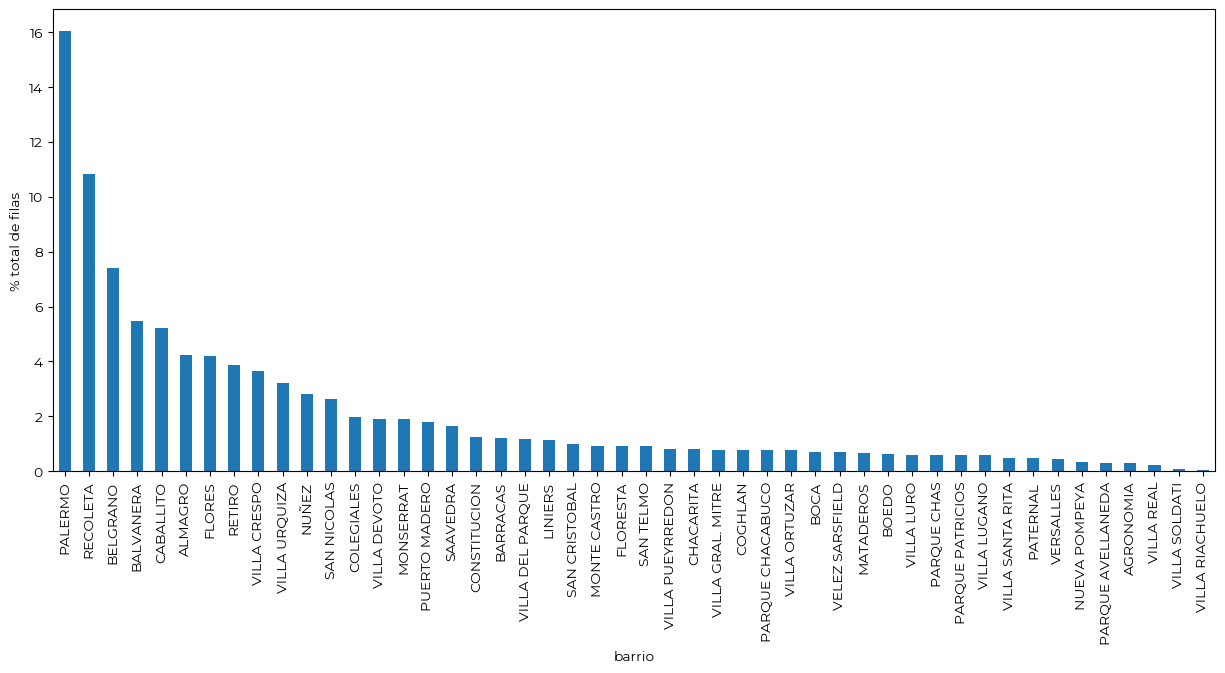

In [149]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,6))
(dataframe.barrio.value_counts(normalize = True)*100).plot(kind = 'bar')
plt.ylabel('% total de filas')
plt.show()

Podemos ver que hay una distribución muy poco pareja entre los distintos barrios. Pasaré a analizarlo más en detalle:

Los 5 barrios con mayor cantidad de inmuebles a la venta significan un porcentaje de:

In [150]:

top_5_barrios = dataframe.groupby('barrio')['property_type'].count().sort_values(ascending=False)[:5]
f'{round((top_5_barrios.sum() / dataframe.shape[0])*100,2) } %'

'44.96 %'

Si tomamos los primeros 10

In [151]:

top_10_barrios = dataframe.groupby('barrio')['property_type'].count().sort_values(ascending=False)[:10]
f'{round((top_10_barrios.sum() / dataframe.shape[0])*100,2) } %'

'64.11 %'

In [152]:
top_20_barrios = dataframe.groupby('barrio')['property_type'].count().sort_values(ascending=False)[:20]
f'{round((top_20_barrios.sum() / dataframe.shape[0])*100, 2)} %'

'82.42 %'

/tmp/ipykernel_81731/51150909.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=dataframe, y="price_usd", x="surface_total", palette= 'pastel')


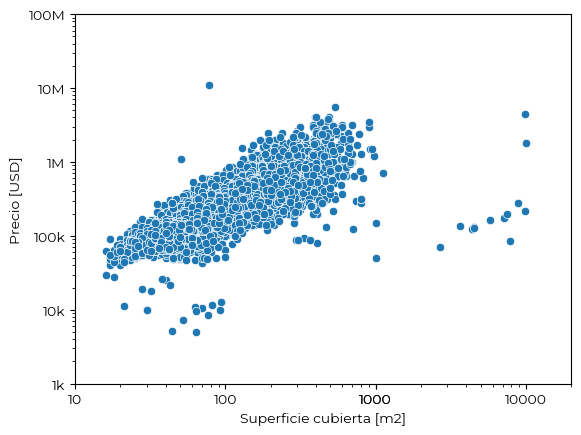

In [153]:
import seaborn as sns
sns.scatterplot(data=dataframe, y="price_usd", x="surface_total", palette= 'pastel')

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Superficie cubierta [m2]')
plt.ylabel('Precio [USD]')
plt.xlim([10,20000])
plt.xticks([10,100,1000,1000,10000],[10,100,1000,1000,10000])
plt.yticks([1000,10000,100000,1000000,10000000,100000000],["1k","10k","100k","1M","10M","100M"])
plt.show()

In [154]:
dataframe[~(dataframe['price_usd']>1000000) & (dataframe['surface_total']<100)]

ID property_type        lat        lon  \
0          0     apartment -34.615181 -58.385944   
6          6     apartment -34.611730 -58.378348   
7          7     apartment -34.616651 -58.390361   
8          8     apartment -34.616651 -58.390361   
10        10     apartment -34.613392 -58.385620   
...      ...           ...        ...        ...   
10557  10557     apartment -34.668741 -58.443146   
10559  10559     apartment -34.665005 -58.443041   
10560  10560     apartment -34.664283 -58.469604   
10562  10562     apartment -34.684843 -58.476648   
10563  10563     apartment -34.694580 -58.475787   

                                             description  \
0      SEMIPISO 2 AMBIENTES. FRENTE. 56 M2. TODO A NU...   
6      Corredor Responsable: Ariel Champanier - C.U.C...   
7      Departamento. Edificio Casa Solis. Living/Come...   
8      Departamento. Edificio Casa Solis. Living/Come...   
10     Excelente Duplex VIP  con vista a parques hast...   
...                                                  ...   
10557  Corredor Responsable: Hernan Perrone - C.U.C.I...   
10559  Corredor Responsable: Raul Hector Merlo - CUCI...   
10560  Corredor Responsable: MARIANO AUFSEHER  - CUCI...   
10562  Departamento 3 ambientes al contrafrente en ed...   
10563  HERMOSO DEPARTAMENTO 3 AMBIENTES AL FRENTE CON...   

                                                   title  price_usd  \
0                      DEPARTAMENTO EN VENTA.|.APARTMENT   119000.0   
6      EXCELENTE ESTADO -APTO CRÉDITO-EDIFICIO EN TOR...   189900.0   
7      Departamento. Edificio Casa Solis. Living/Come...   135947.0   
8      Departamento. Edificio Casa Solis. Living/Come...   138680.0   
10                   La Pampa 1300, Belgrano.|.APARTMENT   340000.0   
...                                                  ...        ...   
10557    Hermoso departamento de 3 ambientes.|.APARTMENT    60000.0   
10559  DEPARTAMENTO 3 AMBIENTES  SOLDATI APTO CRÉDITO...    50433.0   
10560           Depto. de 3 amb APTO CREDITO.|.APARTMENT    75000.0   
10562  Excelente departamento 3 amb c/ cochera.|.APAR...   140000.0   
10563  Departamento en venta, Villa Celina - Ciudad M...    85000.0   

       surface_total  surface_covered  rooms           barrio  comuna  \
0                 56               56      2        MONSERRAT       1   
6                 83               78      4        MONSERRAT       1   
7                 51               51      2        MONSERRAT       1   
8                 51               51      2        MONSERRAT       1   
10                74               66      2        MONSERRAT       1   
...              ...              ...    ...              ...     ...   
10557             55               55      3    VILLA SOLDATI       8   
10559             45               45      3    VILLA SOLDATI       8   
10560             60               58      3    VILLA SOLDATI       8   
10562             51               48      3  VILLA RIACHUELO       8   
10563             83               70      3  VILLA RIACHUELO       8   

       price_per_m2  
0       2125.000000  
6       2287.951807  
7       2665.627451  
8       2719.215686  
10      4594.594595  
...             ...  
10557   1090.909091  
10559   1120.733333  
10560   1250.000000  
10562   2745.098039  
10563   1024.096386  

[6925 rows x 13 columns]

In [155]:
dataframe = dataframe[dataframe['surface_total']>16]
dataframe = dataframe[dataframe['surface_total']<1000]
dataframe = dataframe[dataframe['price_usd']>30000]
dataframe = dataframe[~((dataframe['price_usd']>1000000) & (dataframe['surface_total']<100))]
dataframe = dataframe[dataframe['price_usd']<5000000]
dataframe = dataframe[dataframe['rooms']<10]

In [156]:
def outlier_filter(dataframe):
    media = dataframe['price_usd'].mean()
    desviacion_estandar = dataframe['price_usd'].std()

    # Define el umbral para los outliers
    umbral_superior = media + 2 * desviacion_estandar
    umbral_inferior = media - 2 * desviacion_estandar

    # Filtra los datos para eliminar los outliers
    dataframe_filtrado = dataframe[(dataframe['price_usd'] >= umbral_inferior) & (dataframe['price_usd'] <= umbral_superior)]

    media = dataframe_filtrado['surface_total'].mean()
    desviacion_estandar = dataframe_filtrado['surface_total'].std()

    # Define el umbral para los outliers
    umbral_superior = media + 2 * desviacion_estandar
    umbral_inferior = media - 2 * desviacion_estandar

    # Filtra los datos para eliminar los outliers
    dataframe_filtrado = dataframe_filtrado[(dataframe_filtrado['surface_total'] >= umbral_inferior) & (dataframe_filtrado['surface_total'] <= umbral_superior)]
    return dataframe_filtrado

   
#dataframe = outlier_filter(dataframe,'price_usd')

dataframe.groupby(by=['barrio','property_type']).apply(outlier_filter)
dataframe.groupby(by=['barrio','property_type']).apply(outlier_filter)




ID property_type        lat        lon  \
barrio        property_type                                                    
AGRONOMIA     apartment     10518  10518     apartment -34.592470 -58.494404   
                            10519  10519     apartment -34.592470 -58.494404   
                            10521  10521     apartment -34.590001 -58.489973   
                            10522  10522     apartment -34.592770 -58.476289   
                            10523  10523     apartment -34.592770 -58.476289   
...                                  ...           ...        ...        ...   
VILLA URQUIZA house         8691    8691         house -34.570177 -58.477467   
                            8728    8728         house -34.563217 -58.485710   
                            8732    8732         house -34.571605 -58.504305   
                            8741    8741         house -34.575639 -58.477048   
                            8746    8746         house -34.574029 -58.479186   

                                                                         description  \
barrio        property_type                                                            
AGRONOMIA     apartment     10518  Excelentes 2 ambientes de 53 y 56 m2 con balco...   
                            10519  Agronomía, 3 ambientes al frente, con 2 cocher...   
                            10521  NORBAIRES PROPIEDADES NO ES DUEÑO.IMPERDIBLE D...   
                            10522  Excelente Monoambiente en Agronomía IDEAL INVE...   
                            10523  Excelente Monoambiente en Agronomía IDEAL INVE...   
...                                                                              ...   
VILLA URQUIZA house         8691   Casa en venta de 3 ambientesEsquina, terraza, ...   
                            8728   TERRENO - 8,66 x 27,14 - ZONIFICACIÓN R2B1 - F...   
                            8732   EXCEPCIONAL CASA -  DOBLE ACCESO IDEAL  USO PR...   
                            8741   UEÑO VENDE - SIN COMISION - Casa de 428m2 tota...   
                            8746   Corredor Responsable: MARIANO AUFSEHER  - CUCI...   

                                                                               title  \
barrio        property_type                                                            
AGRONOMIA     apartment     10518  2 ambientes 56 m2 con cochera y baulera. A est...   
                            10519  Agronomía, 3 ambientes con 2 cocheras fija a e...   
                            10521                     Departamento venta.|.APARTMENT   
                            10522   1 y 2 ambientes de POZO - INVERSORES.|.APARTMENT   
                            10523   1 y 2 ambientes de POZO - INVERSORES.|.APARTMENT   
...                                                                              ...   
VILLA URQUIZA house         8691                               CASA EN VENTA.|.HOUSE   
                            8728                        Casa - Villa Urquiza.|.HOUSE   
                            8732   HERMOSA CASA -  QUINCHO - PISCINA - PATIO - PA...   
                            8741                                  Casa venta.|.HOUSE   
                            8746   Casa Sobre lote propio con cochera patio y ter...   

                                   price_usd  surface_total  surface_covered  \
barrio        property_type                                                    
AGRONOMIA     apartment     10518   144000.0             57               47   
                            10519   204000.0             74               62   
                            10521    97000.0             42               38   
                            10522    61500.0             32               30   
                            10523    66500.0             41               37   
...                                      ...            ...              ...   
VILLA URQUIZA house         8691    200000.0            113        

In [157]:
import seaborn as sns

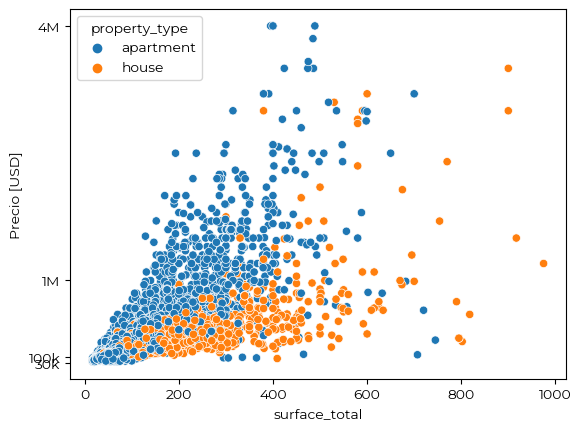

In [158]:
sns.scatterplot(data=dataframe, y="price_usd", x="surface_total",hue='property_type')

#plt.yscale("log")
#plt.xlabel('Superficie cubierta [m2]')
plt.ylabel('Precio [USD]')
#plt.xlim([10,1000])
#plt.legend(bbox_to_anchor =(0.6, 0.8), prop={'size': 8})
#plt.xticks([10,100,1000],[10,100,1000])
plt.yticks([30000,100000,1000000,4000000],["30k","100k","1M",'4M'])
plt.show()

Este metodo funciona a groso modo. Pero debería repetirlo con cada barrio y eso es poco práctico. Por lo que calcularé la media y la mediana de los precios y de las superficies para analizar la presencia de outliers

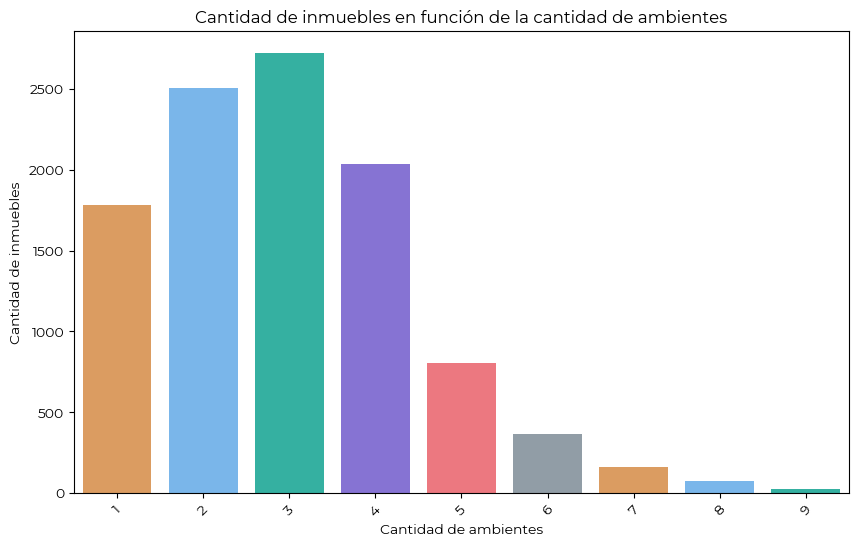

In [159]:
plt.figure(figsize=(10, 6))
#sns.boxplot(x="rooms", y="price_usd", data=dataframe[dataframe['rooms']<=4])
#sns.boxplot(x="rooms", y="price_usd", data=dataframe)
sns.countplot(data=dataframe, x='rooms', palette=["#ef9b4d", '#68b7fc', '#20c4b0','#7c63e3','#ff656f','#8d9da9'])
plt.xlabel('Cantidad de ambientes')
plt.ylabel('Cantidad de inmuebles')
#plt.ylim([10,1000])
#plt.legend()
#plt.yscale('log')
plt.title('Cantidad de inmuebles en función de la cantidad de ambientes')
plt.xticks(rotation=45)
plt.show()

Dado que a partir de los 5 ambientes disminuye mucho la oferta, agruparé todos los que son de 5 ambientes o más en el grupo "5 ambientes"

In [160]:
dataframe_plot = dataframe.copy()
dataframe_plot.loc[dataframe_plot['rooms'] >= 5, 'rooms'] = '5+'
dataframe_plot['rooms'] = dataframe_plot['rooms'].astype(str)
#dataframe_plot['rooms'] = dataframe_plot['rooms'].astype(str)

In [161]:
dataframe_plot.groupby('rooms').count().reset_index()

rooms    ID  property_type   lat   lon  description  title  price_usd  \
0     1  1783           1783  1783  1783         1783   1783       1783   
1     2  2508           2508  2508  2508         2508   2508       2508   
2     3  2723           2723  2723  2723         2723   2723       2723   
3     4  2036           2036  2036  2036         2036   2036       2036   
4    5+  1427           1427  1427  1427         1427   1427       1427   

   surface_total  surface_covered  barrio  comuna  price_per_m2  
0           1783             1783    1783    1783          1783  
1           2508             2508    2508    2508          2508  
2           2723             2723    2723    2723          2723  
3           2036             2036    2036    2036          2036  
4           1427             1427    1427    1427          1427

In [162]:
grupo = dataframe.groupby(by=['barrio','comuna'])['price_usd'].agg(['mean', 'median','std']).reset_index()
print(grupo)


               barrio  comuna          mean    median            std
0           AGRONOMIA      15  2.189793e+05  144500.0  170727.252747
1             ALMAGRO       5  1.734712e+05  145000.0  100759.676445
2           BALVANERA       3  1.469639e+05  129000.0   83080.924777
3            BARRACAS       4  1.986680e+05  170000.0  110496.902278
4            BELGRANO      13  4.242096e+05  270000.0  443540.591536
5                BOCA       4  1.417386e+05  105000.0  141351.317764
6               BOEDO       5  1.682353e+05  129000.0  104459.911989
7           CABALLITO       6  2.117858e+05  180000.0  117654.947890
8           CHACARITA      15  1.991885e+05  140000.0  188678.606261
9             COGHLAN      12  2.163518e+05  163450.0  150599.636032
10         COLEGIALES      13  2.521965e+05  198500.0  159964.982174
11       CONSTITUCION       1  1.292820e+05  113150.0  116985.177049
12             FLORES       7  1.872580e+05  145000.0  126878.504285
13           FLORESTA      10  1.5

Primero analizaremos la oferta total de inmuebles según los ambientes.

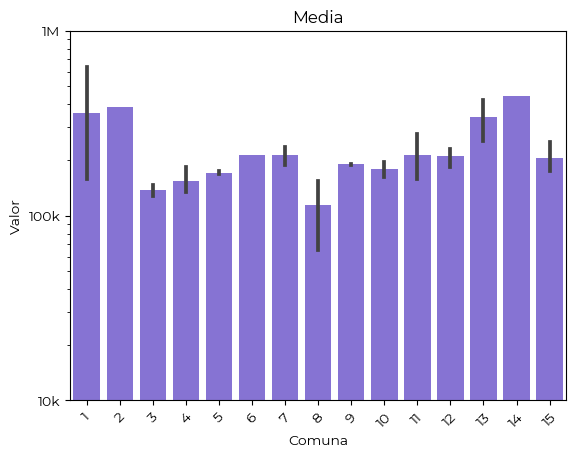

In [163]:
sns.barplot(data=grupo, x='comuna', y='mean',color='#7c63e3')
plt.xlabel('Comuna')
plt.ylabel('Valor')
#plt.ylim([10,1000])
#plt.legend()
plt.yscale('log')
plt.title('Media')
plt.yticks([10000,100000,1000000],["10k","100k","1M"])
plt.xticks(rotation=45)
plt.show()

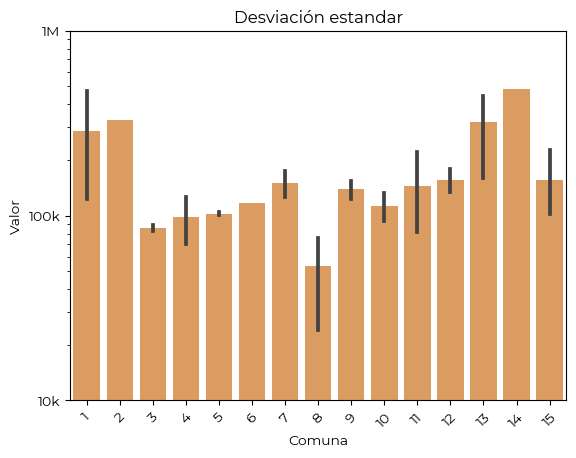

In [164]:
sns.barplot(data=grupo, x='comuna', y='std',palette=["#ef9b4d"])
plt.xlabel('Comuna')
plt.ylabel('Valor')
#plt.ylim([10,1000])
#plt.legend()
plt.yscale('log')
plt.title('Desviación estandar')
plt.yticks([10000,100000,1000000],["10k","100k","1M"])
plt.xticks(rotation=45)
plt.show()

Hay muchos inmuebles en esta comuna y tienen una variedad importante, principalmente entre Constitución y Puerto Madero

Dada la situación de pocos inmuebles que sufre tanto Villa Soldati como Villa Riachuelo no considero que sea necesario evaluar esta comuna por separado

A partir de ahora trabajaré con comunas, con eventuales pausas a estudiar la comuna 1

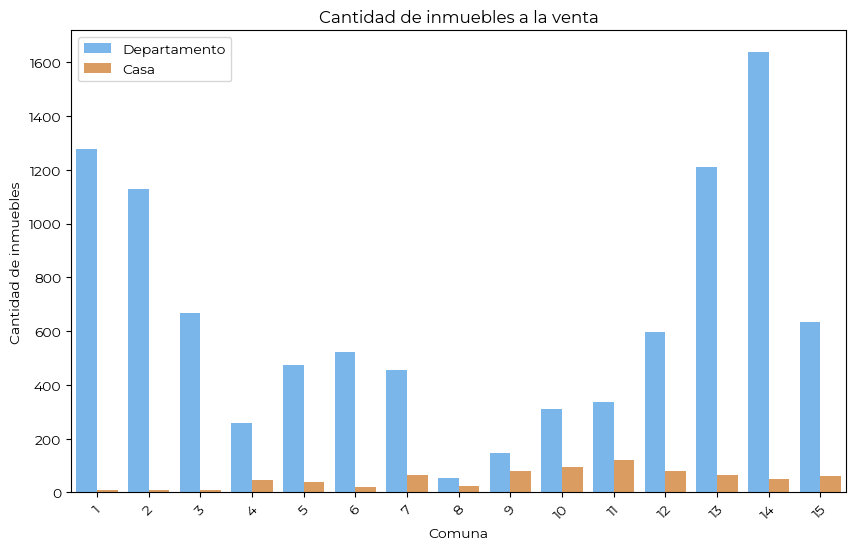

In [165]:
import matplotlib.font_manager as fm
from matplotlib.pyplot import rcParams

fe = fm.FontEntry(
       fname='font/Montserrat-Regular.ttf',
       name='Montserrat')
fm.fontManager.ttflist.insert(0, fe) # or append is fine
plt.rcParams['font.family'] = fe.name
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = fe.name + ':italic'
rcParams['mathtext.bf'] = fe.name + ':italic:bold'


plt.figure(figsize=(10, 6))
sns.countplot(data=dataframe_plot, x='comuna', hue='property_type', palette=["#68b7fc","#ef9b4d"])

plt.xlabel('Comuna')
plt.ylabel('Cantidad de inmuebles')
#plt.ylabel('Valor')
#plt.ylim([10,1000])
#plt.yscale('log')
#plt.color()
plt.legend(['Departamento','Casa'])
plt.title('Cantidad de inmuebles a la venta')
plt.xticks(rotation=45)
plt.show()

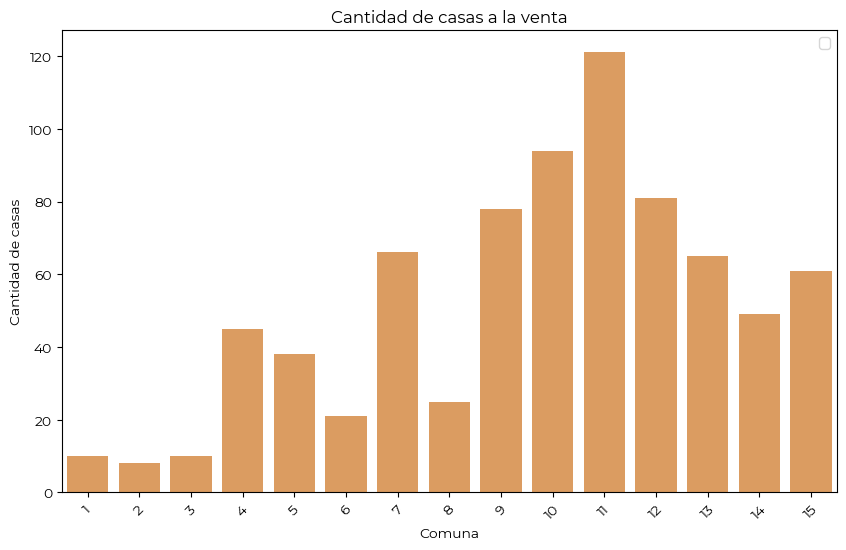

In [166]:
plt.figure(figsize=(10, 6))
sns.countplot(data=dataframe_plot[dataframe_plot['property_type'] == 'house'], x='comuna', color="#ef9b4d")
plt.xlabel('Comuna')
plt.ylabel('Cantidad de casas')
#plt.ylim([10,1000])
#plt.yscale('log')
plt.legend([])
plt.title('Cantidad de casas a la venta')
plt.xticks(rotation=45)
plt.show()

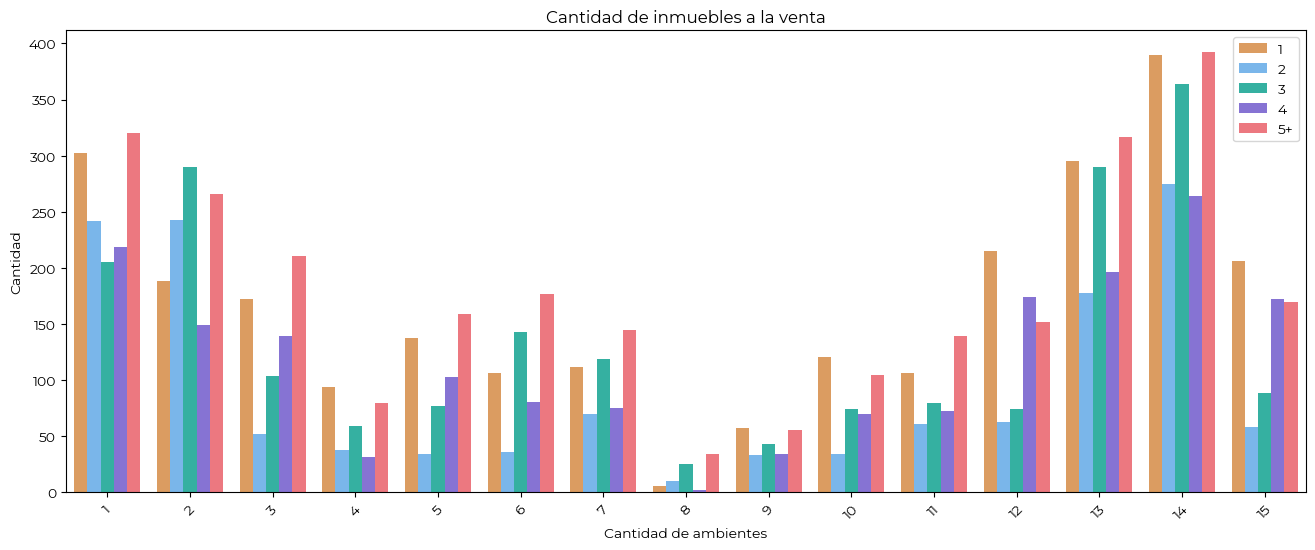

In [167]:
plt.figure(figsize=(16, 6))
sns.countplot(data=dataframe_plot, x='comuna', hue='rooms', palette=["#ef9b4d", '#68b7fc', '#20c4b0','#7c63e3','#ff656f'])

plt.xlabel('Cantidad de ambientes')
plt.ylabel('Cantidad')
#plt.ylim([10,1000])
plt.legend(['1','2','3','4','5+'])
#plt.yscale('log')
plt.title('Cantidad de inmuebles a la venta')
plt.xticks(rotation=45)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


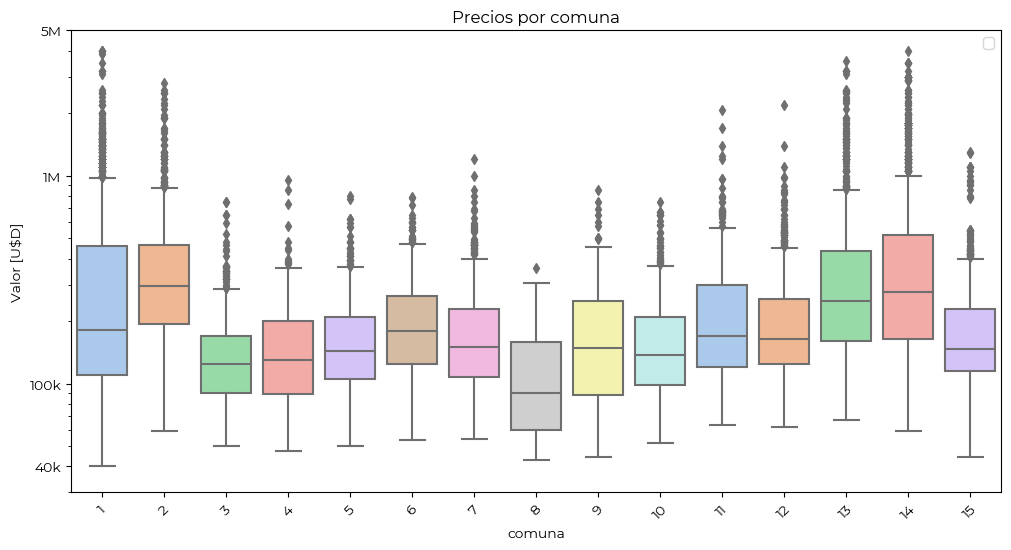

In [168]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=dataframe_plot, x='comuna', y='price_usd', palette="pastel")
plt.ylabel('Valor [U$D]')
plt.ylim([30000,5000000])
plt.yscale('log')
plt.title('Precios por comuna')
plt.legend()
plt.yticks([40000,100000,1000000,5000000],["40k","100k","1M","5M"])
plt.xticks(rotation=45)
plt.show()

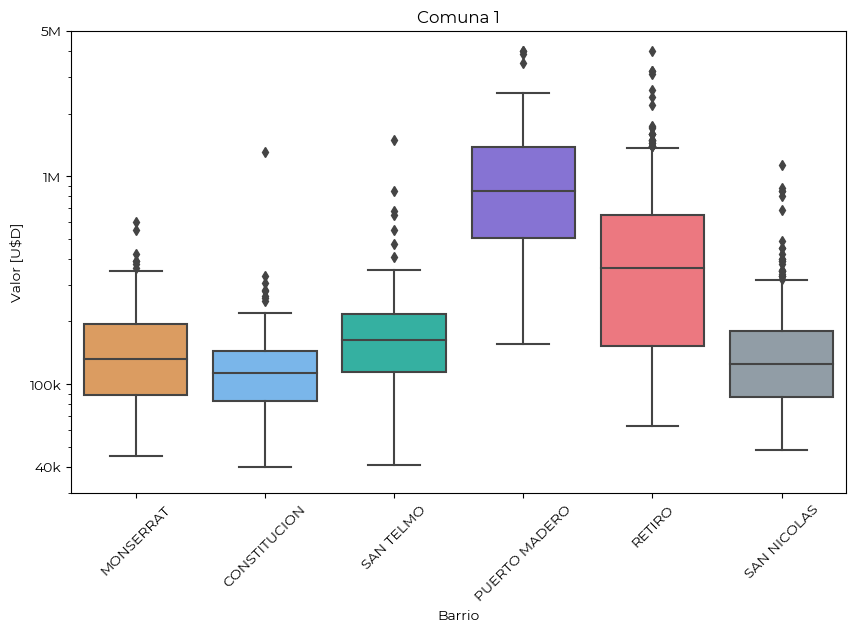

In [169]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataframe_plot[dataframe_plot['comuna']==1], x='barrio', y='price_usd',palette=["#ef9b4d", '#68b7fc', '#20c4b0','#7c63e3','#ff656f','#8d9da9'])
plt.ylabel('Valor [U$D]')
plt.xlabel('Barrio')
plt.ylim([30000,5000000])
plt.yscale('log')
plt.title('Comuna 1')
plt.yticks([40000,100000,1000000,5000000],["40k","100k","1M","5M"])
plt.xticks(rotation=45)
plt.show()

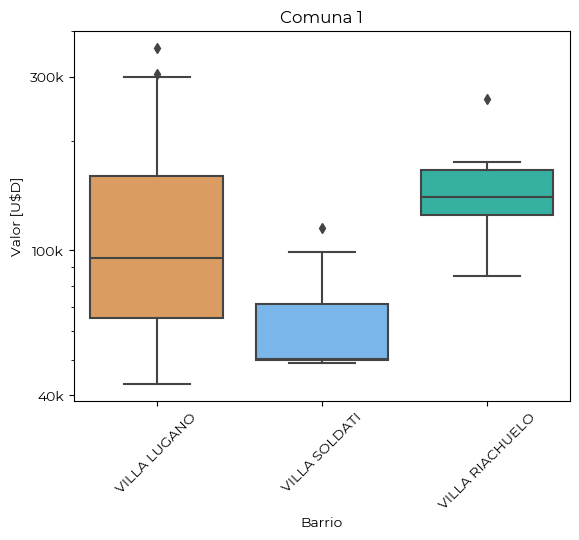

In [170]:
sns.boxplot(data=dataframe_plot[dataframe_plot['comuna']==8], x='barrio', y='price_usd', palette=["#ef9b4d", '#68b7fc', '#20c4b0'])
plt.ylabel('Valor [U$D]')
plt.xlabel('Barrio')
plt.yscale('log')
plt.yticks([40000,100000,300000],["40k","100k",'300k'])
plt.title('Comuna 1')

plt.xticks(rotation=45)
plt.show()

A continuación agreguemos la diferencia entre departamento y casa. Para ver si nos da algo de información

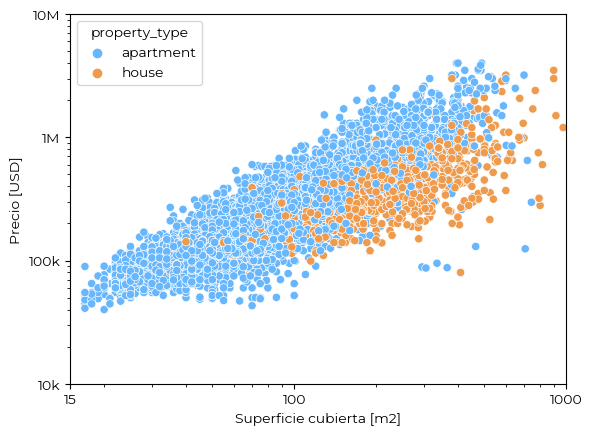

In [171]:
sns.scatterplot(data=dataframe, y="price_usd", x="surface_total",hue='property_type', palette=['#68b7fc',"#ef9b4d"])

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Superficie cubierta [m2]')
plt.ylabel('Precio [USD]')
plt.xlim([15,1000])
#plt.legend(bbox_to_anchor =(0.6, 0.8), prop={'size': 8})
plt.xticks([15,100,1000],[15,100,1000])
plt.yticks([10000,100000,1000000,10000000],["10k","100k","1M","10M"])
plt.show()

Como se puede ver, los inmuebles de mayor tamaño suelen ser las casas. Además a una misma superficie, un departamento es más caro que una casa.

Finalmente voy a revisar aquellos de la zona inferior derecha, aquellos baratos de mucha superficie

In [172]:
dataframe[(dataframe['price_usd']<130000) & (dataframe['surface_total']>250)]

ID property_type        lat        lon  \
5402    5402     apartment -34.602279 -58.397065   
5472    5472     apartment -34.601159 -58.398106   
5758    5758     apartment -34.601044 -58.396992   
5927    5927         house -34.624689 -58.487454   
9086    9086     apartment -34.581850 -58.475633   
10447  10447     apartment -34.577607 -58.507558   

                                             description  \
5402   Estudios JuninModernas Unidades aptas profesio...   
5472   Corredor Responsable: Uno Bienes Raices SRL - ...   
5758   El edificio se emplaza en una zona de gran con...   
5927   VENTA CASA EN LA CALETAEn contruccionDistribui...   
9086   Corredor Responsable: Cristian Arnal Ponti - C...   
10447  Corredor Responsable: Uno Bienes Raices SRL - ...   

                                                   title  price_usd  \
5402   Departamento 335m² 1 ambiente con Plantas en J...    95000.0   
5472       VENTA MONOAMBIENTE EN POZO - ONCE.|.APARTMENT    88604.0   
5758   Departamento 305m² 1 ambiente con Plantas en V...    86900.0   
5927                                  VENTA CASA.|.HOUSE    80000.0   
9086         MONOAMBIENTE AMPLIO  y LUMINOSO.|.APARTMENT    87500.0   
10447  EXCELENTE OPORTUNIDAD - 2amb de pozo V.Puey.|....   124470.0   

       surface_total  surface_covered  rooms            barrio  comuna  \
5402             335              305      1         BALVANERA       3   
5472             295               33      1         BALVANERA       3   
5758             305               27      1         BALVANERA       3   
5927             409              112      3          FLORESTA      10   
9086             365              365      1       PARQUE CHAS      15   
10447            707              307      2  VILLA PUEYRREDON      12   

       price_per_m2  
5402     283.582090  
5472     300.352542  
5758     284.918033  
5927     195.599022  
9086     239.726027  
10447    176.053748

En general son pozos, tienen una superficie cubierta muy baja y una superficie total muy alta, además de que tienen solo una habitación. 

Las descarto porque, nuevamente, son pocas muestras y estoy holgado como para hacerlo

In [173]:

dataframe = dataframe[(dataframe['price_usd']>130000) | (dataframe['surface_total']<250)]


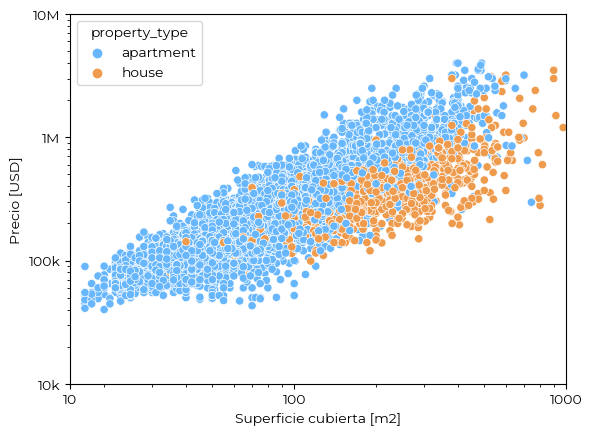

In [174]:
sns.scatterplot(data=dataframe, y="price_usd", x="surface_total", hue='property_type', palette=['#68b7fc',"#ef9b4d"])

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Superficie cubierta [m2]')
plt.ylabel('Precio [USD]')
plt.xlim([15,1000])
#plt.legend(bbox_to_anchor =(0.6, 0.8), prop={'size': 8})
plt.xticks([15,100,1000],[10,100,1000])
#plt.legend(['Departamento','Casa'])
plt.yticks([10000,100000,1000000,10000000],["10k","100k","1M","10M"])
plt.show()

# Evaluación del modelo

In [175]:
#dataframe_cor = dataframe.corr()
#sns.heatmap(dataframe_cor, annot=True, vmin=-1, cmap='Blues')

In [176]:
dataframe.info

<bound method DataFrame.info of           ID property_type        lat        lon  \
0          0     apartment -34.615181 -58.385944   
1          1     apartment -34.613650 -58.389334   
2          2     apartment -34.613650 -58.389334   
3          3     apartment -34.613650 -58.389334   
4          4     apartment -34.613748 -58.377643   
...      ...           ...        ...        ...   
10562  10562     apartment -34.684843 -58.476648   
10563  10563     apartment -34.694580 -58.475787   
10564  10564         house -34.691159 -58.470592   
10565  10565     apartment -34.694841 -58.470328   
10566  10566     apartment -34.685069 -58.475028   

                                             description  \
0      SEMIPISO 2 AMBIENTES. FRENTE. 56 M2. TODO A NU...   
1      Sup total por escritura: 169,06 m2(Sup Cubiert...   
2      Sup total por escritura: 169,06 m2(Sup Cubiert...   
3      Sup total por escritura: 169,06 m2(Sup Cubiert...   
4      Departamento al frente, se compone d

In [177]:
dataframe['comuna'] = dataframe['comuna'].astype(str)
dataframe['rooms'] = dataframe['rooms'].astype(str)
dataframe['pileta'] = dataframe['description'].str.contains(r'pileta|piscina', regex=True).astype(int)
dataframe['balcon'] = dataframe['description'].str.contains(r'balcon', regex=True).astype(int)
dataframe['parrilla'] = dataframe['description'].str.contains(r'parrilla|asador', regex=True).astype(int)
dataframe['terraza'] = dataframe['description'].str.contains(r'terraza', regex=True).astype(int)
dataframe['baulera'] = dataframe['description'].str.contains(r'baulera', regex=True).astype(int)
dataframe['jardin'] = dataframe['description'].str.contains(r'jardin|patio', regex=True).astype(int)
dataframe['lavadero'] = dataframe['description'].str.contains(r'lavadero', regex=True).astype(int)
dataframe['subte'] = dataframe['description'].str.contains(r'subte|linea|estacion', regex=True).astype(int)
dataframe_dummie = pd.get_dummies(dataframe.drop(['ID','lat','lon','description','title',], axis=1), drop_first=True).astype(int)
#dataframe_dummie['property_type_apartment'] = dataframe_dummie['property_type_apartment'].astype(int)
#dataframe_dummie['property_type_house'] = dataframe_dummie['property_type_house'].astype(int)
#dataframe_dummie['rooms_1'] = dataframe_dummie['rooms_1'].astype(int)
#dataframe_dummie = dataframe_dummie.astype(int)
dataframe_dummie.reset_index(inplace=True)

In [178]:
dataframe_dummie.iloc[22]


index                  22
price_usd          140000
surface_total          66
surface_covered        56
price_per_m2         2121
                    ...  
comuna_5                0
comuna_6                0
comuna_7                0
comuna_8                0
comuna_9                0
Name: 22, Length: 83, dtype: int64

<Axes: >

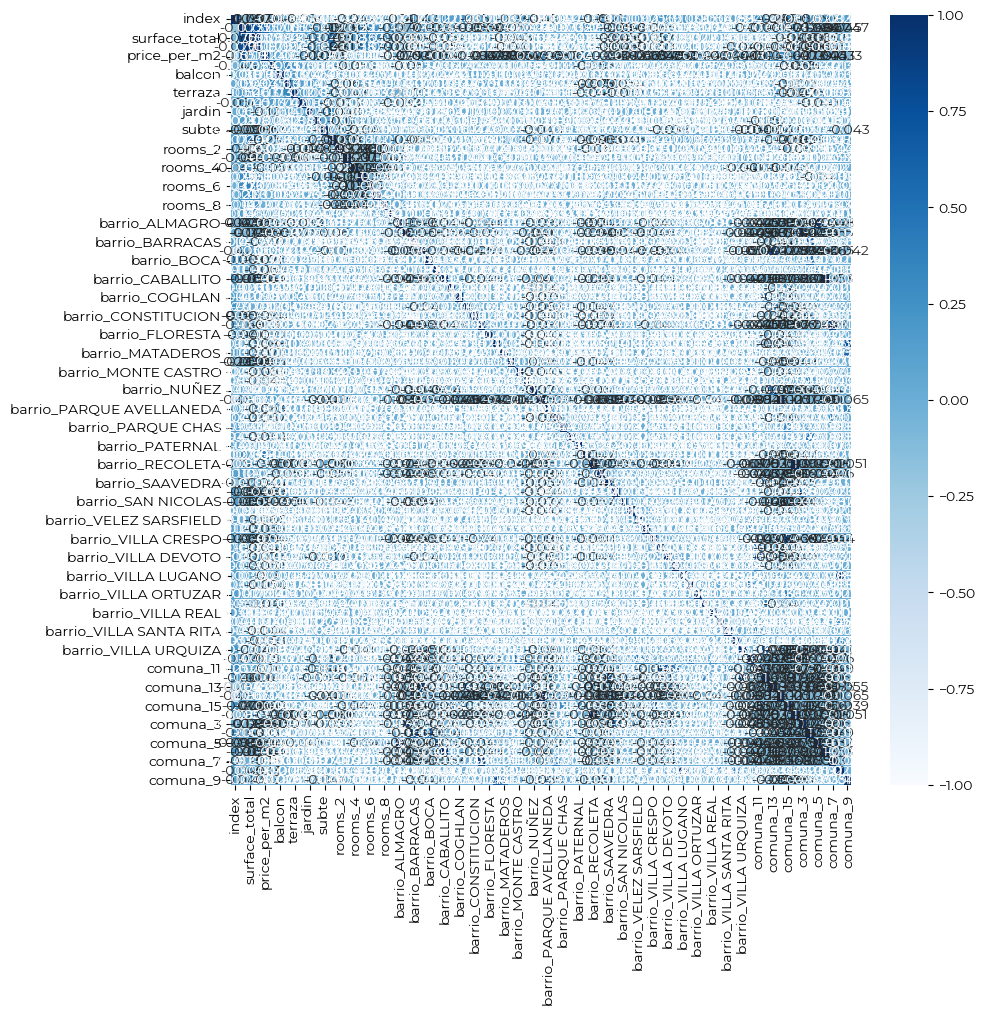

In [179]:
plt.figure(figsize=(10,10))
dataframe_cor = dataframe_dummie.corr()
sns.heatmap(dataframe_cor, annot=True, vmin=-1, cmap='Blues')


In [180]:
dataframe_dummie.info

<bound method DataFrame.info of        index  price_usd  surface_total  surface_covered  price_per_m2  pileta  \
0          0     119000             56               56          2125       0   
1          1     270000            169              167          1597       0   
2          2     270000            169              167          1597       0   
3          3     270000            169              167          1597       0   
4          4     180000            104               96          1730       0   
...      ...        ...            ...              ...           ...     ...   
10465  10562     140000             51               48          2745       0   
10466  10563      85000             83               70          1024       0   
10467  10564     140000            185              120           756       0   
10468  10565     120000            125               70           960       0   
10469  10566     175000            160              128          1093       0

In [181]:
dataframe_dummie.columns

Index(['index', 'price_usd', 'surface_total', 'surface_covered',
       'price_per_m2', 'pileta', 'balcon', 'parrilla', 'terraza', 'baulera',
       'jardin', 'lavadero', 'subte', 'property_type_house', 'rooms_2',
       'rooms_3', 'rooms_4', 'rooms_5', 'rooms_6', 'rooms_7', 'rooms_8',
       'rooms_9', 'barrio_ALMAGRO', 'barrio_BALVANERA', 'barrio_BARRACAS',
       'barrio_BELGRANO', 'barrio_BOCA', 'barrio_BOEDO', 'barrio_CABALLITO',
       'barrio_CHACARITA', 'barrio_COGHLAN', 'barrio_COLEGIALES',
       'barrio_CONSTITUCION', 'barrio_FLORES', 'barrio_FLORESTA',
       'barrio_LINIERS', 'barrio_MATADEROS', 'barrio_MONSERRAT',
       'barrio_MONTE CASTRO', 'barrio_NUEVA POMPEYA', 'barrio_NUÑEZ',
       'barrio_PALERMO', 'barrio_PARQUE AVELLANEDA', 'barrio_PARQUE CHACABUCO',
       'barrio_PARQUE CHAS', 'barrio_PARQUE PATRICIOS', 'barrio_PATERNAL',
       'barrio_PUERTO MADERO', 'barrio_RECOLETA', 'barrio_RETIRO',
       'barrio_SAAVEDRA', 'barrio_SAN CRISTOBAL', 'barrio_SAN NICOLAS',


In [182]:
dataframe_dummie.info

<bound method DataFrame.info of        index  price_usd  surface_total  surface_covered  price_per_m2  pileta  \
0          0     119000             56               56          2125       0   
1          1     270000            169              167          1597       0   
2          2     270000            169              167          1597       0   
3          3     270000            169              167          1597       0   
4          4     180000            104               96          1730       0   
...      ...        ...            ...              ...           ...     ...   
10465  10562     140000             51               48          2745       0   
10466  10563      85000             83               70          1024       0   
10467  10564     140000            185              120           756       0   
10468  10565     120000            125               70           960       0   
10469  10566     175000            160              128          1093       0

In [183]:
dataframe_dummie.columns.to_list()

['index',
 'price_usd',
 'surface_total',
 'surface_covered',
 'price_per_m2',
 'pileta',
 'balcon',
 'parrilla',
 'terraza',
 'baulera',
 'jardin',
 'lavadero',
 'subte',
 'property_type_house',
 'rooms_2',
 'rooms_3',
 'rooms_4',
 'rooms_5',
 'rooms_6',
 'rooms_7',
 'rooms_8',
 'rooms_9',
 'barrio_ALMAGRO',
 'barrio_BALVANERA',
 'barrio_BARRACAS',
 'barrio_BELGRANO',
 'barrio_BOCA',
 'barrio_BOEDO',
 'barrio_CABALLITO',
 'barrio_CHACARITA',
 'barrio_COGHLAN',
 'barrio_COLEGIALES',
 'barrio_CONSTITUCION',
 'barrio_FLORES',
 'barrio_FLORESTA',
 'barrio_LINIERS',
 'barrio_MATADEROS',
 'barrio_MONSERRAT',
 'barrio_MONTE CASTRO',
 'barrio_NUEVA POMPEYA',
 'barrio_NUÑEZ',
 'barrio_PALERMO',
 'barrio_PARQUE AVELLANEDA',
 'barrio_PARQUE CHACABUCO',
 'barrio_PARQUE CHAS',
 'barrio_PARQUE PATRICIOS',
 'barrio_PATERNAL',
 'barrio_PUERTO MADERO',
 'barrio_RECOLETA',
 'barrio_RETIRO',
 'barrio_SAAVEDRA',
 'barrio_SAN CRISTOBAL',
 'barrio_SAN NICOLAS',
 'barrio_SAN TELMO',
 'barrio_VELEZ SARSFIELD

Corramos una versión basica, unicamente dada por la superficie.

In [184]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

model = LinearRegression(fit_intercept=True)
feature_cols = ['surface_total', 'surface_covered','price_per_m2']
X = dataframe_dummie[feature_cols]
y = dataframe_dummie.price_usd

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

scaler = StandardScaler()
scaler.fit_transform(Xtrain)

model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
ypred_train = model.predict(Xtrain)

print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(4))


MAE: 72194.09
MSE: 18721058243.14
RMSE: 136824.92
R2: 0.8479


Arroja un R2 de 0.5898

Si ahora le agregamos el criterio de numero de ambientes, de barrios y de comunas:

In [185]:

model = LinearRegression(fit_intercept=True)
feature_cols = ['surface_total', 'surface_covered','price_per_m2',
       'property_type_house', 'rooms_2', 'rooms_3', 'rooms_4', 'rooms_5',
       'rooms_6', 'rooms_7', 'rooms_8', 'rooms_9', 'barrio_ALMAGRO',
       'barrio_BALVANERA', 'barrio_BARRACAS', 'barrio_BELGRANO', 'barrio_BOCA',
       'barrio_BOEDO', 'barrio_CABALLITO', 'barrio_CHACARITA',
       'barrio_COGHLAN', 'barrio_COLEGIALES', 'barrio_CONSTITUCION',
       'barrio_FLORES', 'barrio_FLORESTA', 'barrio_LINIERS',
       'barrio_MATADEROS', 'barrio_MONSERRAT', 'barrio_MONTE CASTRO',
       'barrio_NUEVA POMPEYA', 'barrio_NUÑEZ', 'barrio_PALERMO',
       'barrio_PARQUE AVELLANEDA', 'barrio_PARQUE CHACABUCO',
       'barrio_PARQUE CHAS', 'barrio_PARQUE PATRICIOS', 'barrio_PATERNAL',
       'barrio_PUERTO MADERO', 'barrio_RECOLETA', 'barrio_RETIRO',
       'barrio_SAAVEDRA', 'barrio_SAN CRISTOBAL', 'barrio_SAN NICOLAS',
       'barrio_SAN TELMO', 'barrio_VELEZ SARSFIELD', 'barrio_VERSALLES',
       'barrio_VILLA CRESPO', 'barrio_VILLA DEL PARQUE', 'barrio_VILLA DEVOTO',
       'barrio_VILLA GRAL. MITRE', 'barrio_VILLA LUGANO', 'barrio_VILLA LURO',
       'barrio_VILLA ORTUZAR', 'barrio_VILLA PUEYRREDON', 'barrio_VILLA REAL',
       'barrio_VILLA RIACHUELO', 'barrio_VILLA SANTA RITA',
       'barrio_VILLA SOLDATI', 'barrio_VILLA URQUIZA', 'comuna_10',
       'comuna_11', 'comuna_12', 'comuna_13', 'comuna_14', 'comuna_15',
       'comuna_2', 'comuna_3', 'comuna_4', 'comuna_5', 'comuna_6', 'comuna_7',
       'comuna_8', 'comuna_9']


X = dataframe_dummie[feature_cols]
y = dataframe_dummie.price_usd

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

scaler = StandardScaler()
scaler.fit_transform(Xtrain)

model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
ypred_train = model.predict(Xtrain)

print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(3))


MAE: 68638.07
MSE: 16981040535.43
RMSE: 130311.32
R2: 0.862


Subió a un nada despreciable 0.712

/home/mantiago/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


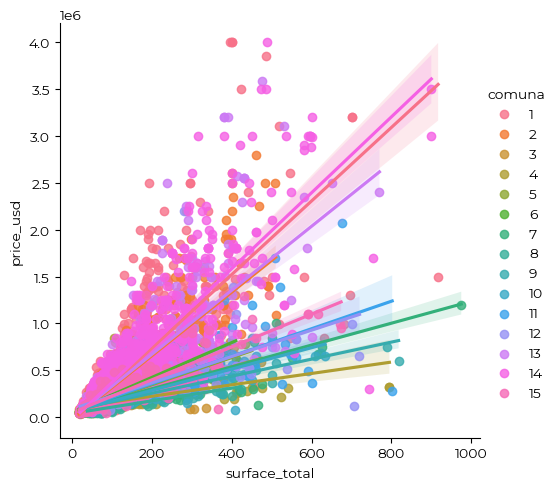

In [186]:
sns.lmplot(data=dataframe_plot, x='surface_total', hue='comuna', y='price_usd')
#plt.xlim([0,100])
#plt.ylim([0,100000])

## Nuevos features

Existen diversas features que pueden sumar al precio de un inmueble. 
Por ejemplo:
- Pileta
- Balcon
- Parrilla
- Terraza
- Baulera	
- Jardin
- lavadero
- Acceso al subte
- Seguridad

In [187]:
print('pileta', dataframe['description'].str.contains('pileta', case=False).sum())
print('pileta', dataframe['description'].str.contains('piscina', case=False).sum())
print('balcon', dataframe['description'].str.contains('balcon', case=False).sum())
print('parrilla', dataframe['description'].str.contains('parrilla', case=False).sum())
print('terraza', dataframe['description'].str.contains('terraza', case=False).sum())
print('baulera', dataframe['description'].str.contains('baulera', case=False).sum())
print('jardin', dataframe['description'].str.contains('jardin', case=False).sum())
print('lavadero', dataframe['description'].str.contains('lavadero', case=False).sum())
print('Cercania al subte', dataframe['description'].str.contains('subte', case=False).sum())     
print('plaza', dataframe['description'].str.contains('plaza', case=False).sum())     

pileta 898
pileta 1182
balcon 2064
parrilla 2335
terraza 2778
baulera 2083
jardin 423
lavadero 4072
Cercania al subte 2333
plaza 934


Generaremos nuevas columnas en base a esto

In [188]:
model = LinearRegression(fit_intercept=True)
feature_cols = ['surface_total', 'surface_covered','price_per_m2',
       'property_type_house', 'rooms_2', 'rooms_3', 'rooms_4', 'rooms_5',
       'rooms_6', 'rooms_7', 'rooms_8', 'rooms_9', 'barrio_ALMAGRO',
       'barrio_BALVANERA', 'barrio_BARRACAS', 'barrio_BELGRANO', 'barrio_BOCA',
       'barrio_BOEDO', 'barrio_CABALLITO', 'barrio_CHACARITA',
       'barrio_COGHLAN', 'barrio_COLEGIALES', 'barrio_CONSTITUCION',
       'barrio_FLORES', 'barrio_FLORESTA', 'barrio_LINIERS',
       'barrio_MATADEROS', 'barrio_MONSERRAT', 'barrio_MONTE CASTRO',
       'barrio_NUEVA POMPEYA', 'barrio_NUÑEZ', 'barrio_PALERMO',
       'barrio_PARQUE AVELLANEDA', 'barrio_PARQUE CHACABUCO',
       'barrio_PARQUE CHAS', 'barrio_PARQUE PATRICIOS', 'barrio_PATERNAL',
       'barrio_PUERTO MADERO', 'barrio_RECOLETA', 'barrio_RETIRO',
       'barrio_SAAVEDRA', 'barrio_SAN CRISTOBAL', 'barrio_SAN NICOLAS',
       'barrio_SAN TELMO', 'barrio_VELEZ SARSFIELD', 'barrio_VERSALLES',
       'barrio_VILLA CRESPO', 'barrio_VILLA DEL PARQUE', 'barrio_VILLA DEVOTO',
       'barrio_VILLA GRAL. MITRE', 'barrio_VILLA LUGANO', 'barrio_VILLA LURO',
       'barrio_VILLA ORTUZAR', 'barrio_VILLA PUEYRREDON', 'barrio_VILLA REAL',
       'barrio_VILLA RIACHUELO', 'barrio_VILLA SANTA RITA',
       'barrio_VILLA SOLDATI', 'barrio_VILLA URQUIZA', 'comuna_10',
       'comuna_11', 'comuna_12', 'comuna_13', 'comuna_14', 'comuna_15',
       'comuna_2', 'comuna_3', 'comuna_4', 'comuna_5', 'comuna_6', 'comuna_7',
       'comuna_8', 'comuna_9','pileta','balcon','parrilla','terraza',
       'baulera','jardin','lavadero','subte']


X = dataframe_dummie[feature_cols]
y = dataframe_dummie.price_usd

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

scaler = StandardScaler()
scaler.fit_transform(Xtrain)

model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
ypred_train = model.predict(Xtrain)

print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(3))


MAE: 69334.13
MSE: 17066888960.04
RMSE: 130640.3
R2: 0.861


In [189]:
lassocv = linear_model.LassoCV(alphas=[5, 10], cv=5)
modelo_cv = lassocv.fit(Xtrain, ytrain)
print(modelo_cv.score(Xtrain, ytrain))
print(modelo_cv.coef_)
print(modelo_cv.alpha_)

ypred = lassocv.predict(Xtest)

0.864626975818156
[ 2.05890507e+03  1.19147294e+03  1.66144619e+02 -1.75836708e+05
 -2.63987792e+03 -5.92469367e+02  6.48569528e+03  1.65792244e+04
 -1.69542508e+03 -3.79162886e+04 -1.47126891e+04 -1.05863097e+04
  0.00000000e+00  0.00000000e+00 -2.51173410e+04 -9.06249514e+01
 -0.00000000e+00  2.51359703e+04 -1.77815640e+03 -3.67590139e+04
 -4.37347247e+04  0.00000000e+00  4.72891317e+04  1.41529781e+04
  4.71511359e+03  2.10159422e+04  4.61252755e+03 -1.36418498e+03
 -0.00000000e+00  4.48352136e+04 -6.10515879e+02 -3.73537914e+04
 -3.90678515e+03 -2.35036785e+04 -9.29724709e+03  4.61770872e+04
  2.10696641e+04 -8.10303946e+04 -5.78705655e+04 -3.52086612e+04
 -0.00000000e+00  1.86285503e+04  4.09295130e+03 -1.03643369e+04
 -2.09144242e+04 -9.06774121e+03 -2.94683600e+04 -1.25039697e+04
  4.06395513e+03 -1.08200748e+03  0.00000000e+00  1.90799692e+03
 -7.51239269e+04  3.72243650e+04  2.70896350e+04 -0.00000000e+00
  2.15991653e+04  1.09967965e+05 -1.30071897e+04  3.53363987e+04
  0.000

In [190]:
ridgecv = linear_model.RidgeCV(alphas=[0.00006, 0.00007, 0.0001, 0.0002, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], cv=5)
modelo_cv = ridgecv.fit(Xtrain, ytrain)
print(modelo_cv.coef_)
print(modelo_cv.score(Xtrain, ytrain))
print(modelo_cv.coef_)
print(modelo_cv.alpha_)

[ 2.04684533e+03  1.19038930e+03  1.65430835e+02 -1.70045680e+05
 -2.47486701e+03 -2.16079697e+02  7.13060809e+03  1.72439765e+04
 -8.28926696e+02 -3.46725689e+04 -1.24498613e+04 -8.59597352e+03
 -4.74568498e+03  3.13769824e+03 -3.18870551e+04 -1.12403541e+04
 -7.75861033e+03  1.71025115e+04 -6.98588378e+03 -1.95665268e+04
 -3.68437242e+04 -1.08764909e+04  4.55330457e+04  1.76431480e+04
  1.09974646e+04  1.53007917e+04  2.81567089e+02  9.86598591e+02
  4.99009936e+03  2.69918446e+04 -1.23641054e+04 -2.59609145e+04
 -9.04877993e+03 -1.88902422e+04  3.19534715e+03  3.08143878e+04
  2.96044263e+04 -7.02038662e+04 -3.32240557e+04 -3.02018497e+04
  1.76105025e+03  2.00820831e+04  7.07837487e+03 -7.44697276e+03
 -1.33944607e+04 -4.41425877e+03 -1.39546817e+04 -1.29831486e+04
  2.40873178e+03 -3.29516353e+03  5.28675848e+03  8.32186526e+03
 -5.26802412e+04  3.44113472e+04  2.44862184e+04 -1.87277660e+03
  1.75980275e+04  5.53440382e+04 -1.04774698e+04  3.09869281e+04
  3.72844714e+03 -1.11487

## Geopandas

Descargamos un dataset de barrios

https://drive.google.com/file/d/1gJi1bdqm8hxNWZdcbmV183QkdzmtKu0j/view?usp=drive_link

In [191]:
def format_lat_lon(string, name='lat' ):
    if type(string[name]) is float:
        print(string[name])
        return string
    string = string.str.replace('.', '')
    lat_lon_formatted = float(string[name][:3] + '.' + string[name][3:])
    return lat_lon_formatted

In [192]:
#dataframe['lat'] = dataframe.apply(format_lat_lon, args=('lat',), axis=1)
#dataframe['lon'] = dataframe.apply(format_lat_lon, args=('lon',), axis=1)
print(max(dataframe['lat']), min(dataframe['lat']))
print(max(dataframe['lon']), min(dataframe['lon']))

-34.5364401 -34.6948412611
-58.354381 -58.52924347


/home/mantiago/.local/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


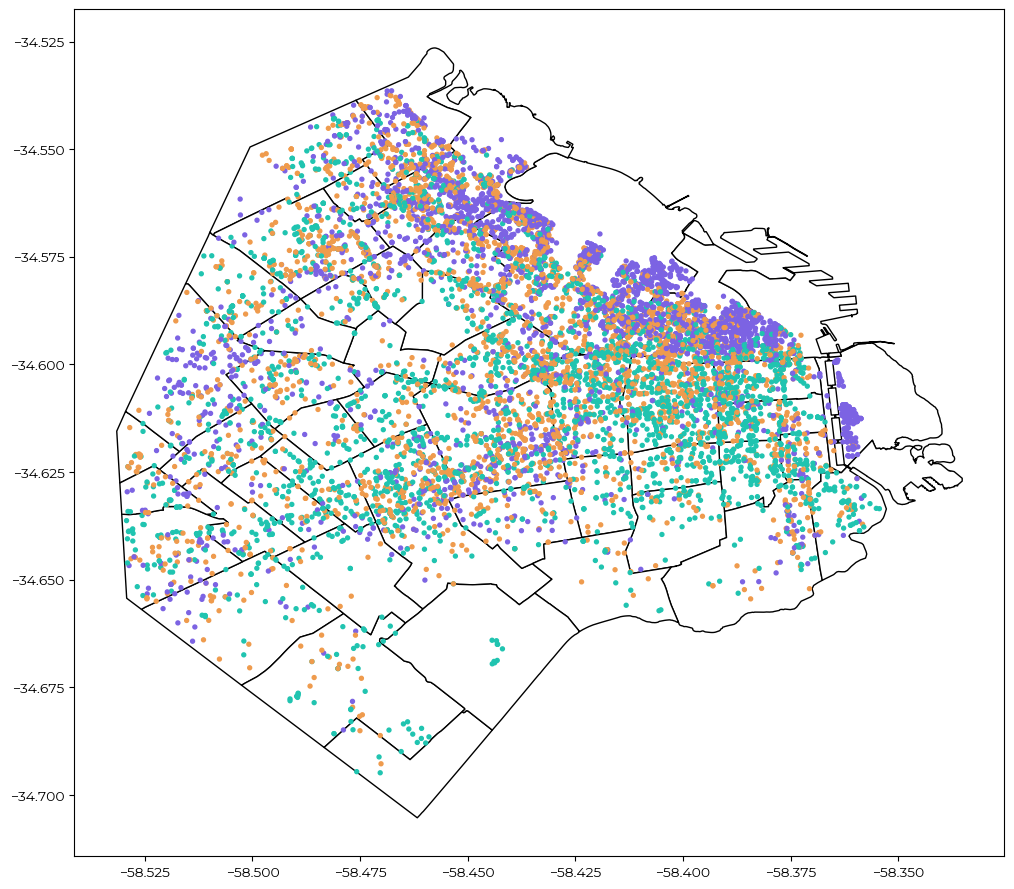

In [193]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import shape
import shapely
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from shapely import Point
import geopandas as gpd
import numpy as np


def plot_CABA(dataframe, serie):

    barrios = pd.read_csv('datasets/barrios.csv', sep=';', encoding='UTF-8')
    geometry = barrios['WKT'].apply(shapely.wkt.loads)
    barrios_csv =  barrios.drop('WKT', axis=1)
    crs = {'init': 'epsg:4326'}
    barrios_geo = gpd.GeoDataFrame(None, crs=crs, geometry=geometry)

    #ax.set_aspect('equal')

    #barrios_geo.plot(ax=ax, figsize= size)

    geometry = [Point(lon, lat) for lon, lat in zip(dataframe['lon'], dataframe['lat'])]
    gdf = gpd.GeoDataFrame(dataframe, geometry=geometry, crs='EPSG:4326')  # Asegúrate de usar la proyección adecuada (EPSG:4326 es para latitud y longitud)

    size = (12,12)
    fig, ax = plt.subplots(figsize = size, sharex='all', sharey='all')
    ax.set_aspect('equal')
    #barrios_geo.plot(ax=ax, figsize= size)

    geometry = gpd.points_from_xy(pd.to_numeric(dataframe['lon']), pd.to_numeric(dataframe['lat']))

    inmuebles = gpd.GeoDataFrame(serie, geometry=geometry)

    barrios_geo.plot(ax=ax, color='white', edgecolor='black')

    ax.set_aspect('equal')
    inmuebles.plot(ax=ax, color = dataframe['color'], markersize=8)
    plt.show()

# Color mapping function
def get_color(value,percentiles):
    if value <= percentiles[0]:
        return '#20c4b0'
    elif value <= percentiles[1]:
        return "#ef9b4d"
    else:
        return '#7c63e3'
    
'''def get_color(value):
    if value == 'house':
        return 'red'
    elif value == 'apartment':
        return 'green'''

# Assign colors based on percentiles
palette=["#ef9b4d", '#68b7fc', '#20c4b0','#7c63e3','#ff656f','#8d9da9']
percentiles = np.percentile(dataframe['price_usd'].to_numpy(), [33, 66]) 
dataframe['color'] = dataframe['price_usd'].apply(get_color,args=(percentiles,))

#dataframe['color'] = dataframe['property_type'].apply(get_color)

serie = dataframe['price_usd']
plot_CABA(dataframe, serie)


/home/mantiago/.local/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


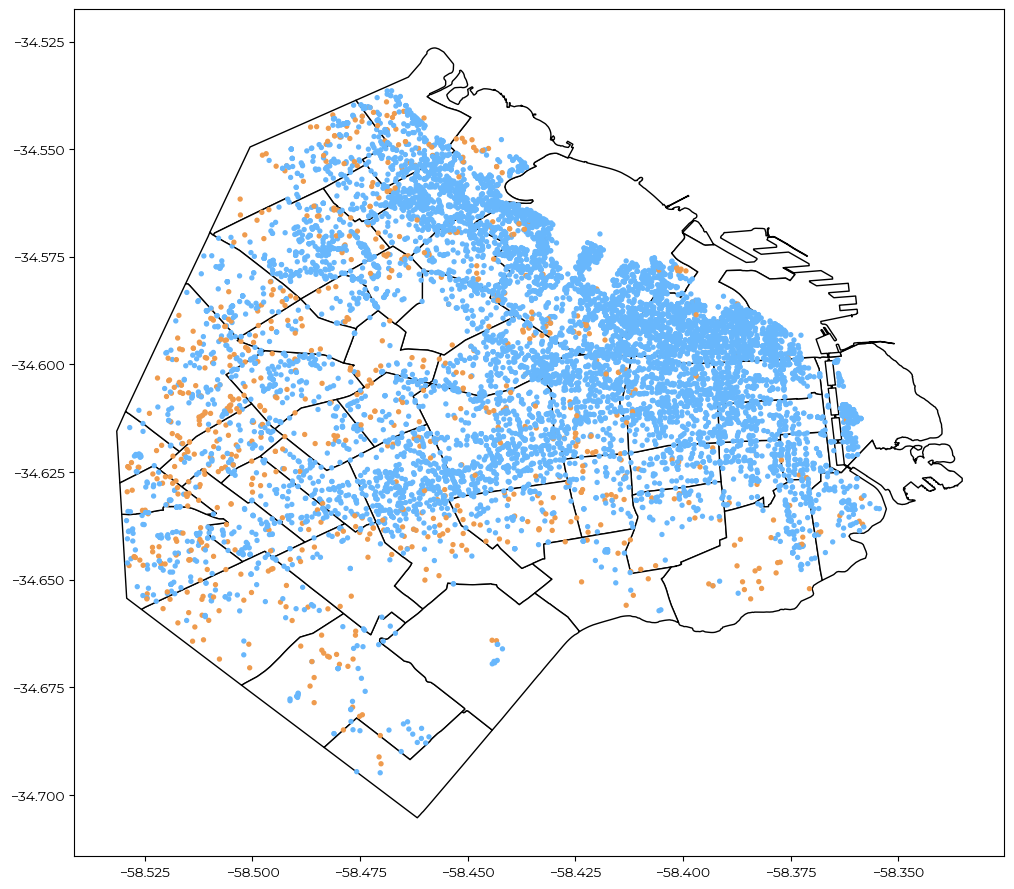

In [194]:
def get_color_property(value):
    if value == 'house':
        return "#ef9b4d"
    elif value == 'apartment':
        return '#68b7fc'
    
# Assign colors based on percentiles
palette=["#ef9b4d", '#68b7fc', '#20c4b0','#7c63e3','#ff656f','#8d9da9']

dataframe['color'] = dataframe['property_type'].apply(get_color_property)


serie = dataframe['price_usd']
plot_CABA(dataframe, serie)

In [195]:
from shapely.geometry import LineString

# Agrupar elementos por línea


# Crear un LineString para cada grupo de elementos

def subte_lines(estaciones):

    print(estaciones['linea'])
    grupos = estaciones.groupby('linea')
    line_strings=[]
    for linea, group in grupos:
        # Crea una lista de coordenadas a partir de las columnas "lat" y "long" en el grupo.
        coordinates = list(zip(group['long'], group['lat']))
        
        # Crea un objeto LineString a partir de las coordenadas.
        line = LineString(coordinates)
        
        # Agrega el LineString a la lista.
        line_strings.append(line)
    return line_strings

In [196]:
import shapely

/home/mantiago/.local/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


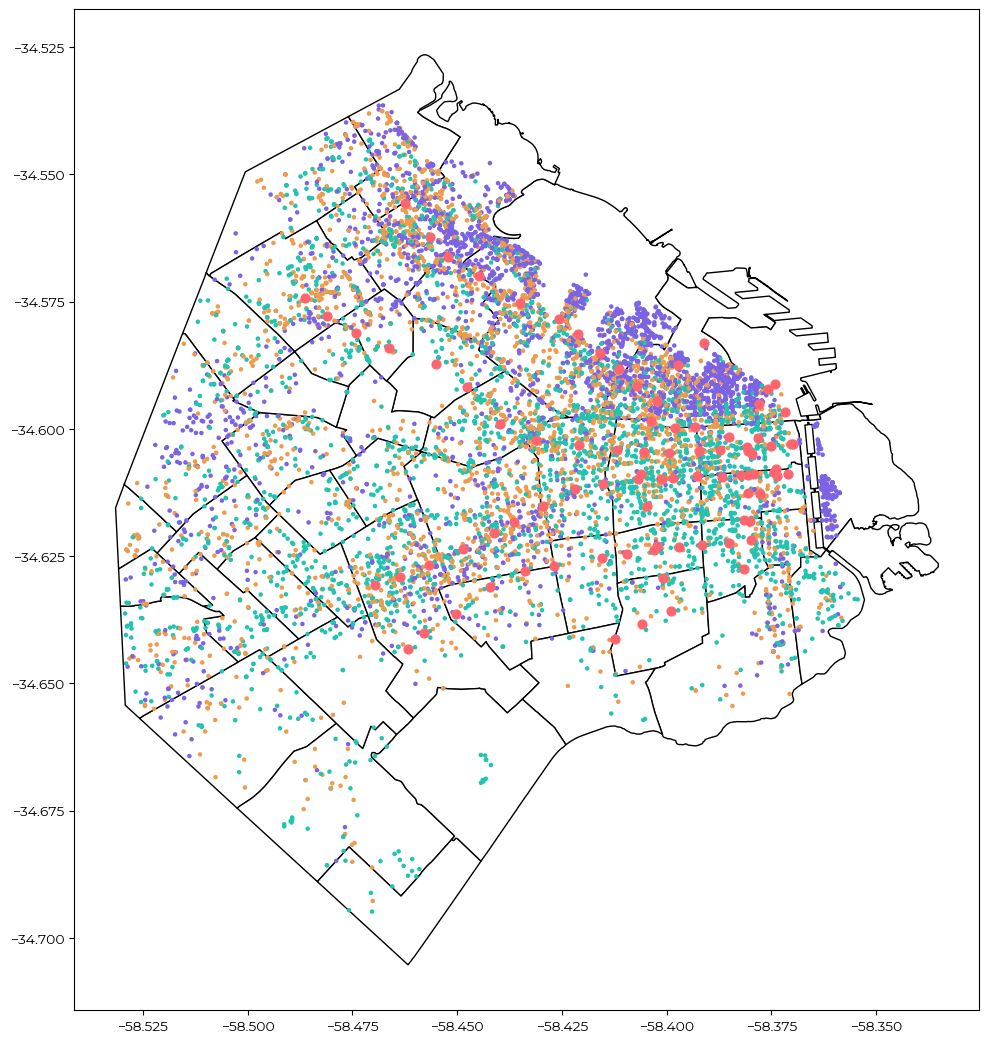

In [197]:
from shapely.geometry import shape
import shapely
from shapely import wkt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import shape
import shapely
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely import Point
import seaborn as sns


def plot_SUBTE_CABA(dataframe, serie):

    barrios = pd.read_csv('datasets/barrios.csv', sep=';', encoding='UTF-8')
    geometry = barrios['WKT'].apply(shapely.wkt.loads)
    barrios_csv =  barrios.drop('WKT', axis=1)
    crs = {'init': 'epsg:4326'}
    barrios_geo = gpd.GeoDataFrame(None, crs=crs, geometry=geometry)

    estaciones = pd.read_csv('datasets/estaciones-de-subte.csv', sep=',', encoding='UTF-8')
    #geometry_subte = subte_lines(estaciones)
    #geometry_subte = [Point(lon, lat) for lon, lat in zip(estaciones['long'], estaciones['lat'])]

    geometry = [Point(lon, lat) for lon, lat in zip(dataframe['lon'], dataframe['lat'])]

    geometry_subte = [Point(lon, lat) for lon, lat in zip(estaciones['long'], estaciones['lat'])]
    
    gdf = gpd.GeoDataFrame(dataframe, geometry=geometry, crs='EPSG:4326')  # Asegúrate de usar la proyección adecuada (EPSG:4326 es para latitud y longitud)

    gdf_subte = gpd.GeoDataFrame(estaciones, geometry=geometry_subte, crs='EPSG:4326')  # Asegúrate de usar la proyección adecuada (EPSG:4326 es para latitud y longitud)
    #gdf_subte_lines = subte_lines(estaciones)
    #gdf_subte_lines = gpd.GeoDataFrame(gdf_subte_lines, geometry=gdf_subte_lines)

    size = (13,13)
    fig, ax = plt.subplots(figsize = size)
    ax.set_aspect('equal')
    barrios_geo.plot(ax=ax, figsize= size)

    geometry = gpd.points_from_xy(pd.to_numeric(dataframe['lon']), pd.to_numeric(dataframe['lat']))

    geometry = gpd.points_from_xy(pd.to_numeric(estaciones['long']), pd.to_numeric(estaciones['lat']))

    #inmuebles = gpd.GeoDataFrame(serie, geometry=geometry)


    barrios_geo.plot(ax=ax, color='white', edgecolor='black')

    ax.set_aspect('equal')
    gdf.plot(ax=ax, color = dataframe['color'], markersize=5)
    gdf_subte.plot(ax=ax, markersize=40,color='#ff656f')
    #gdf_subte_lines.plot(ax=ax, markersize=2)
    plt.show()

percentiles = np.percentile(dataframe['price_usd'].to_numpy(), [33, 66]) 
dataframe['color'] = dataframe['price_usd'].apply(get_color,args=(percentiles,))
serie = dataframe['price_usd']
plot_SUBTE_CABA(dataframe, serie)

## Preguntas

Junto con la consigna se agregaron varias preguntas. Estas son:

1) ¿Cuál es el ID del inmueble que requiere mayor gasto/inversión (‘price_usd’ +
‘expenses’) para adquirirlo?
2) Cual es el ID de la casa (‘house’) que tiene una superficie descubierta de al menos
800 m2 y su valor (‘price_usd’) es el más barato?
3) Obtener el TOP de las 3 propiedades más caras, para cada tipo de propiedad.
4) Obtener el valor promedio de las propiedades para cada barrio.
5) ¿Cuál es la comuna con más propiedades a la venta?
6) ¿Cuál es el barrio con mayor costo promedio por metro cuadrado cubierto?

Para todas las preguntas retomaremos el dataframe original, con los outliers que luego se eliminaron para mejorar la performance del modelo

In [206]:
   
dataframe_original['price_usd'] = dataframe_original.apply(replace_k, axis=1)

 La primera pregunta dice incluir tanto precio como expensas. No tengo como dato el valor del dolar para el momento (ya que las expensas se expresan en pesos) de este dataframe, pero no lo considero necesario a menos que los dos primeros inmuebles den valores muy cercanos entre si y las expensas desempaten

In [207]:
#The most expensive
    
dataframe_original.sort_values('price_usd', ascending=False).iloc[0].ID

6528

La respuesta a ciegas sería 6528. Pero el precio de este inmueble no es real, por lo cual considero que debería hacer un analisis un cachito mejor:

In [208]:
dataframe_original.sort_values('price_usd', ascending=False).head(5)

ID property_type                      lat                      lon  \
6528  6528     apartment              -34.640.267              -58.457.566   
753    753     apartment  -34.552.541.600.000.000  -58.439.522.600.000.000   
2977  2977     apartment  -34.577.253.595.500.000         -584.249.601.349   
5034  5034     apartment              -34.613.262  -58.359.553.500.000.000   
6735  6735     apartment             -345.915.884  -58.383.162.399.999.900   

                                            description  \
6528  Venta de Departamento 3 AMBIENTES en Flores, C...   
753   Triplex en Forum Alcorta, 4 SUITES en 600 metr...   
2977  espectacular depto con ista al frenteESTAS PRO...   
5034  CONTACTO LEONEL 15  IMPORTANTE PISO 400 M2 CHA...   
6735  dos cocheras fijas vigilanciaPISO externo con ...   

                                                  title   price_usd  \
6528                  DEPARTAMENTO EN VENTA.|.APARTMENT  11111111.0   
753   Triplex en Forum Alcorta - Belgrano Chico.|.AP...   5500000.0   
2977                 Departamento - Palermo.|.APARTMENT   4520000.0   
5034  IMPORTANTE PISO 400 M2 CHATEAU PUERTO MADERO.|...   4000000.0   
6735  EXCELENTE PISO EN EDIFICIO DE GRAN CATEGORIA e...   4000000.0   

      surface_total  surface_covered  floor  rooms  expenses         barrio  \
6528             78               68    7.0      3       NaN         FLORES   
753             533              478    NaN      6   40000.0       BELGRANO   
2977           9874               54    NaN      7       NaN        PALERMO   
5034            400              400    NaN      7       NaN  PUERTO MADERO   
6735            400              380    NaN      5       NaN         RETIRO   

      comuna  
6528       7  
753       13  
2977      14  
5034       1  
6735       1

Ahora si, en base a ver un poco más de informacion podriamos decir que el segundo es aquel que tiene un valor más alto. El departamento de Belgrano, ya que el valor del departamento de Flores fue ingresado de forma simbólica. Y las expensas solo están en este inmueble dentro del top 5, así que podemos despreciarlas a la hora de analizar cual es el más caro.

In [209]:
dataframe_original.sort_values('price_usd', ascending=False).iloc[1].ID

753

2) Cual es el ID de la casa (‘house’) que tiene una superficie descubierta de al menos
800 m2 y su valor (‘price_usd’) es el más barato?

In [216]:
cond_1=(dataframe_original['property_type']=='house')
cond_2=((dataframe_original['surface_total']-dataframe_original['surface_covered'])>800)

dataframe_original[cond_1 & cond_2].sort_values('price_usd', ascending=False).iloc[0].ID

1124

In [211]:
dataframe_original[(dataframe_original['surface_total']-dataframe_original['surface_covered']>800)]

ID property_type                      lat                      lon  \
972    972     apartment  -34.569.959.999.999.900  -58.463.145.999.999.900   
1076  1076     apartment              -34.563.139              -58.451.042   
1124  1124         house         -345.727.682.531  -58.460.661.555.600.000   
1220  1220     apartment         -346.314.154.275         -583.827.231.787   
2454  2454     apartment              -34.591.239              -58.412.025   
2903  2903         house             -345.867.893             -584.129.846   
2911  2911     apartment              -34.583.192  -58.441.621.999.999.900   
2977  2977     apartment  -34.577.253.595.500.000         -584.249.601.349   
6675  6675         house              -34.641.047  -58.445.764.000.000.000   
7810  7810     apartment         -345.963.659.942         -584.464.294.929   

                                            description  \
972   Corredor Responsable: Uno Bienes Raices SRL - ...   
1076  Corredor Responsable: Raul Hector Merlo - CUCI...   
1124  Venta de Casa 7 AMBIENTES O MAS en Belgrano R,...   
1220  DEPARTAMENTO DE 2 AMBIENTES CON PATIO EN VENTA...   
2454  Corredor Responsable: MARIANO AUFSEHER - CUCIC...   
2903  COSTA ESMERALDA BARRIO EQUESTRE EXCELENTE CHAL...   
2911  Corredor Responsable: Luis Varela - CSI 5527 /...   
2977  espectacular depto con ista al frenteESTAS PRO...   
6675  Corredor Responsable: Hernan Perrone - C.U.C.I...   
7810  Corredor Responsable: Ariel Champanier - C.U.C...   

                                                  title  price_usd  \
972   VENTA Lindísimo 2 ambientes APTO CREDITO.|.APA...   125000.0   
1076  PISO 4 DORMITORIOS, DEP/ BAULERA Y VALET PARKI...   790000.0   
1124                              CASA EN VENTA.|.HOUSE  1800000.0   
1220                  DEPARTAMENTO EN VENTA.|.APARTMENT    85000.0   
2454  Venta 4 ambientes cochera y baulera Alto Paler...   275000.0   
2903                            COSTA ESMERALDA.|.HOUSE   150000.0   
2911      3  amb Balcón Amenities Apto Prof.|.APARTMENT   176680.0   
2977                 Departamento - Palermo.|.APARTMENT  4520000.0   
6675           Ph al fente tipo casa con garage.|.HOUSE   185000.0   
7810  HERMOSO DEPARTAMENTO CON COCHERA Y BAULERA.|.A...   198900.0   

      surface_total  surface_covered  floor  rooms  expenses  \
972            4394               39   16.0      2       NaN   
1076          23120            20953   25.0      6       NaN   
1124          10000              550    NaN      7       NaN   
1220           7781               31    NaN      2    1500.0   
2454           8875             7927    4.0      4       NaN   
2903           1000              190    NaN      4       NaN   
2911           7170             5450    NaN      3       NaN   
2977           9874               54    NaN      7       NaN   
6675         184000           150000    NaN      5       NaN   
7810           7475               80    4.0      4       NaN   

                barrio  comuna  
972           BELGRANO      13  
1076          BELGRANO      13  
1124          BELGRANO      13  
1220      CONSTITUCION       1  
2454           PALERMO      14  
2903           PALERMO      14  
2911           PALERMO      14  
2977           PALERMO      14  
6675  PARQUE CHACABUCO       7  
7810      VILLA CRESPO      15

3- Obtener el TOP de las 3 propiedades más caras, para cada tipo de propiedad.

In [212]:
dataframe_original.groupby(by='property_type').apply(lambda x: x.sort_values(by='price_usd',ascending=False).head(3))

ID property_type                      lat  \
property_type                                                     
apartment     6528  6528     apartment              -34.640.267   
              753    753     apartment  -34.552.541.600.000.000   
              2977  2977     apartment  -34.577.253.595.500.000   
house         2836  2836         house  -34.569.765.000.000.000   
              2329  2329         house               -3.457.764   
              1790  1790         house             -345.782.966   

                                        lon  \
property_type                                 
apartment     6528              -58.457.566   
              753   -58.439.522.600.000.000   
              2977         -584.249.601.349   
house         2836  -58.439.282.999.999.900   
              2329  -58.401.492.000.000.000   
              1790             -584.011.985   

                                                          description  \
property_type                                                           
apartment     6528  Venta de Departamento 3 AMBIENTES en Flores, C...   
              753   Triplex en Forum Alcorta, 4 SUITES en 600 metr...   
              2977  espectacular depto con ista al frenteESTAS PRO...   
house         2836  Corredor Responsable: Gustavo Guastello - C.U....   
              2329  Corredor Responsable: IGNACIO FEIJOO - CUCICBA...   
              1790  Imponente casa de 3 plantas con ascensor en Pa...   

                                                                title  \
property_type                                                           
apartment     6528                  DEPARTAMENTO EN VENTA.|.APARTMENT   
              753   Triplex en Forum Alcorta - Belgrano Chico.|.AP...   
              2977                 Departamento - Palermo.|.APARTMENT   
house         2836            Casa Palermo 6 ambientes o mas..|.HOUSE   
              2329  VENTA CASA SEÑORIAL Bo. Parque con jardin y pi...   
              1790                       Casa - Palermo Chico.|.HOUSE   

                     price_usd  surface_total  surface_covered  floor  rooms  \
property_type                                                                  
apartment     6528  11111111.0             78               68    7.0      3   
              753    5500000.0            533              478    NaN      6   
              2977   4520000.0           9874               54    NaN      7   
house         2836   3500000.0            900              900    NaN      6   
              2329   3200000.0            600              530    NaN      9   
              1790   3000000.0            590              380    NaN      6   

                    expenses    barrio  comuna  
property_type                                   
apartment     6528       NaN    FLORES       7  
              753    40000.0  BELGRANO      13  
              2977       NaN   PALERMO      14  
house         2836       NaN   PALERMO      14  
              2329       NaN   PALERMO      14  
              1790       NaN   PALERMO      14

4) Obtener el valor promedio de las propiedades para cada barrio.

In [213]:
dataframe_original.groupby('barrio')['price_usd'].mean().apply(round)

barrio
AGRONOMIA             218979
ALMAGRO               173272
BALVANERA             148236
BARRACAS              198668
BELGRANO              434403
BOCA                  141739
BOEDO                 168235
CABALLITO             212537
CHACARITA             202210
COGHLAN               216352
COLEGIALES            264435
CONSTITUCION          134486
FLORES                213250
FLORESTA              151243
LINIERS               191293
MATADEROS             197231
MONSERRAT             159414
MONTE CASTRO          194917
NUEVA POMPEYA         146604
NUÑEZ                 350100
PALERMO               447955
PARQUE AVELLANEDA     188118
PARQUE CHACABUCO      235632
PARQUE CHAS           153356
PARQUE PATRICIOS      134076
PATERNAL              170591
PUERTO MADERO        1001446
RECOLETA              390862
RETIRO                511134
SAAVEDRA              225551
SAN CRISTOBAL         127332
SAN NICOLAS           163728
SAN TELMO             207568
VELEZ SARSFIELD       160566
VERSALL

5) ¿Cuál es la comuna con más propiedades a la venta?

In [214]:
dataframe_original.groupby('barrio').count().sort_values('ID',ascending=False).iloc[0].ID

1693

6. ¿Cuál es el barrio con mayor costo promedio por metro cuadrado cubierto?

In [215]:
dataframe_exercise_6 = dataframe_original.copy()
dataframe_exercise_6['price_per_m2'] = dataframe_original['price_usd'] / dataframe_original['surface_total']
dataframe_exercise_6.groupby(by='barrio')['price_per_m2'].mean().sort_values(ascending=False).index[0]

'PUERTO MADERO'